---
# <div align="center"><font color='black'>  </font></div>
# <div align="center"><font color='black'> COSC 2673 | Machine Learning  </font></div>
## <div align="center"> <font color='black'> Assignment 02: S3712611_Minh Hoang Nguyen, s3828276_Ngoc Vy Le </font></div>
---

# **Notebook Summary**

- This notebook presents our investigation and results for the traffic sign classification task requried in Project 1.


- The 2 dataset that was used in this notebook are the modified *Belgium Traffic Sign Recognition dataset* and the *Australian Traffic Sign dataset*, which was specifically collected for the purpose of testing real world models performance (the 2 dataset will be provided along with this notebook).

- For convinience sake, this notebook will only contain step by step observations/actions/reasons for parameters tuning; it will only discuss briefly on testing performance. Full evaluation of these models can be found in the 5 pages report attracted with this submission. 

`Note: This notebook is requried to be run on Google Colab as the code was designed to work on this specific platform (can also be run on local machine but need to alter the folder path).`




Please follow the steps below to set up the environment on Google Colab correctly:
- Import all required library.
- Mounting colab to google drive so models can be saved and reuse. 
- Upload the two dataset provided to root folder of colab (navigate using the side bar).
- Extracted dataset from zip file will be saved in the content folder. 


# **Importing Library**

In [1]:
!pip install -q -U keras-tuner
!pip install tensorflow-hub
!pip install split-folders


     |████████████████████████████████| 133 kB 12.8 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import os
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import tensorflow as tf
import cv2

from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

from keras import layers, Input
from keras.layers import InputLayer
from keras.layers.core import Dense, Flatten
from keras.models import Sequential, Model
import tensorflow_hub as hub
import keras_tuner as kt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

import matplotlib.image as mpimg

from PIL import Image
import seaborn as sns

import shutil
import splitfolders
from zipfile import ZipFile
from google.colab import drive

tf.__version__

AUTOTUNE = tf.data.experimental.AUTOTUNE

# Set Up Google Colab Working Environment

In [3]:
# Mounted to google drive so model can be saved
drive.mount('/content/gdrive')      

Mounted at /content/gdrive


In [4]:
!mkdir /content/gdrive/'My Drive'/COSC2673_2110/   # create a folder to save the model

mkdir: cannot create directory ‘/content/gdrive/My Drive/COSC2673_2110/’: File exists


In [5]:
def extract_zip_file(file_name):
  with ZipFile(file_name, 'r') as zip:
    zip.extractall()
    print('Zip File Extraction Complete')

In [6]:
# If the zip files are extracted without error then log a message
extract_zip_file('/trafficsigns_dataset.zip') 
extract_zip_file('/independent_data.zip')

Zip File Extraction Complete
Zip File Extraction Complete


# **1. Data Preparation**


## 1.1 **Image Visualization**


In [7]:
def image_visualizer(test_folder):
  """
  This function is used to visualize the image in the given folders. 
  :param test_folder: (str) The absolute path to the folder 
  """
  plt.figure(figsize=(20,20))
  for i in range(5):                                                    
      file = random.choice(os.listdir(test_folder))
      image_path= os.path.join(test_folder, file)
      img=mpimg.imread(image_path)
      ax=plt.subplot(1,5,i+1)
      ax.title.set_text(file)
      plt.imshow(img, cmap = 'gray')

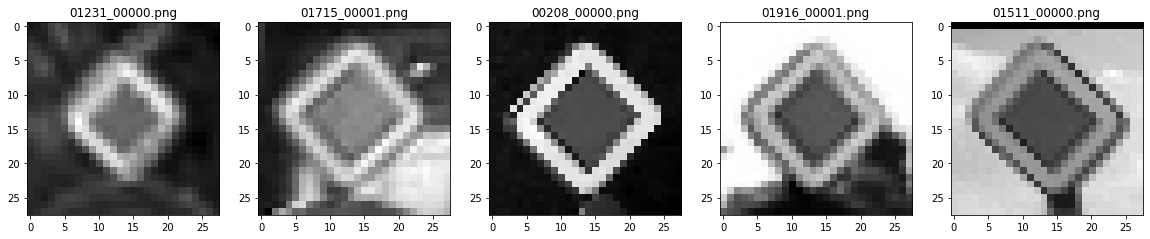

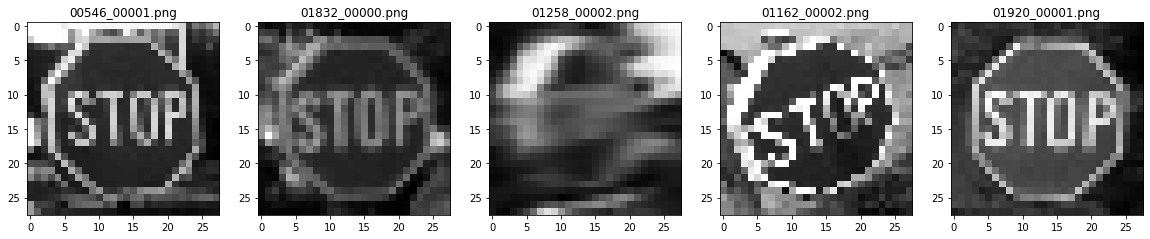

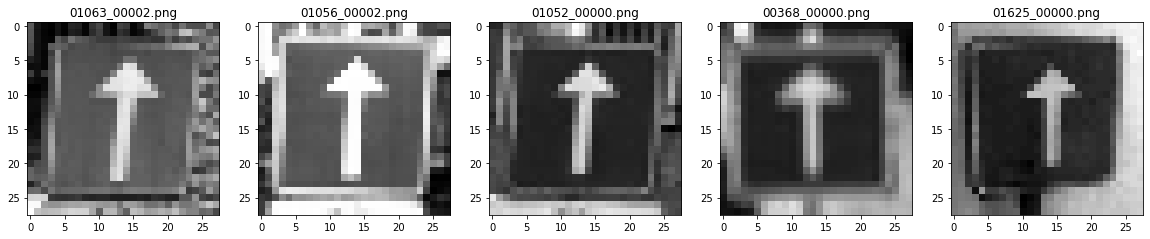

In [8]:
# Belgium traffic sign images
image_visualizer(r'/content/trafficsigns_dataset/diamond/rightofway')
image_visualizer(r'/content/trafficsigns_dataset/hex/stop')
image_visualizer(r'/content/trafficsigns_dataset/square/continue')

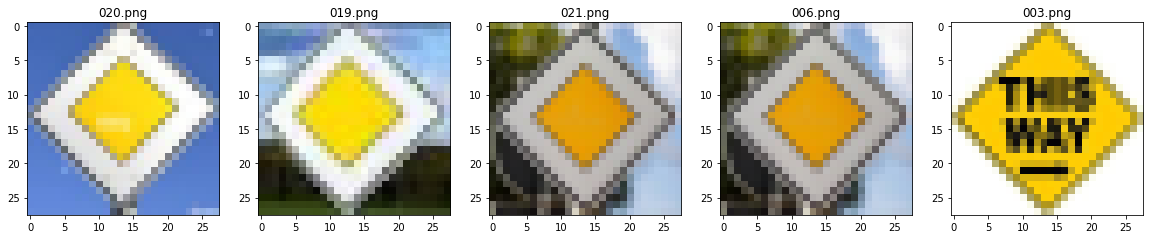

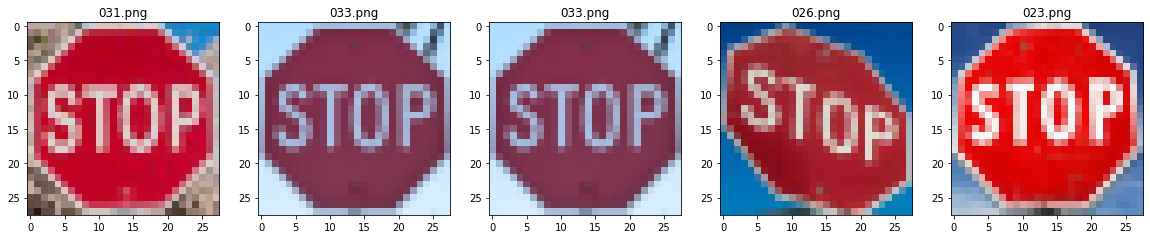

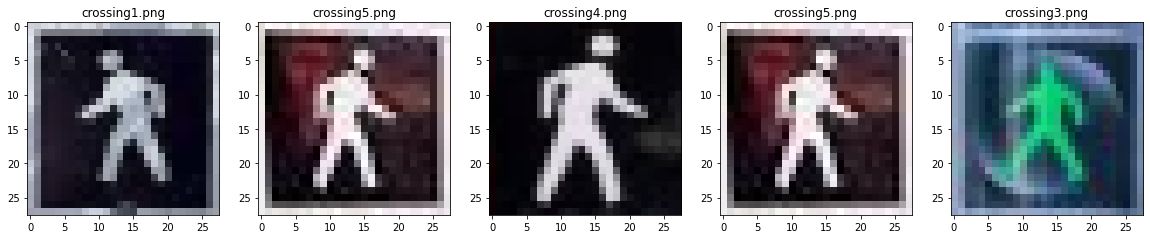

In [9]:
# Australian traffic sign images
image_visualizer(r'/content/independent_data/diamond/rightofway')
image_visualizer(r'/content/independent_data/hex/stop')
image_visualizer(r'/content/independent_data/square/crossing')

**Observations:**
- The Belgium Traffic Sign Dataset has greyscale images.
- The Australian Traffic Sign Dataset has RGB images.

## 1.2 **Split data into Train, Val, Test Folder**

In [10]:
def split_data(ratio, first_run):
    """
    This function is used to split the trafficsign_dataset into smaller train, test, validation folders.
    :param ratio: (tuple) the ratio for (train, test, validation).
    :param first_run: (boolean) if this is first runtime on this notebook.
    """
    if first_run is False:
      # Removing existing folder
      shutil.rmtree(r'./train_test')      
  
    # create train test folder
    splitfolders.ratio('trafficsigns_dataset', output="train_test", ratio = ratio, seed=123)
    
    shapes = ['diamond', 'hex', 'round', 'square', 'triangle']
    diamond =["rightofway"]
    hex_ = [ 'stop']
    round_ = ['bicycle', 'limitedtraffic', 'noentry', 'noparking', 'roundabout', 'speed', 'trafficdirective', 'traveldirection']
    square = ['continue', 'crossing', 'laneend', 'parking']
    triangle = ['giveway', 'warning']
    
    # split data into train, test based on shape
    for shape in shapes:
        src = 'trafficsigns_dataset/' + shape
        dest = 'split/' + shape 
        splitfolders.ratio(src, output=dest, ratio=ratio, seed=123)
   
    # move train, set into a new folder
    shutil.move('./split/diamond/val/rightofway', './train_test/val/diamond/rightofway')
    shutil.move('./split/diamond/train/rightofway', './train_test/train/diamond/rightofway')
    shutil.move('./split/diamond/test/rightofway', './train_test/test/diamond/rightofway')
                  
    shutil.move('./split/hex/val/stop', './train_test/val/hex/stop')
    shutil.move('./split/hex/train/stop', './train_test/train/hex/stop')
    shutil.move('./split/hex/test/stop', './train_test/test/hex/stop')
            
           
    for i in round_:
        path_src = './split/round/val/' + i
        path_dest = './train_test/val/round/' + i
        shutil.move(path_src, path_dest)

        path_src = './split/round/train/' + i
        path_dest = './train_test/train/round/' + i
        shutil.move(path_src, path_dest)
        
        path_src = './split/round/test/' + i
        path_dest = './train_test/test/round/' + i
        shutil.move(path_src, path_dest)
              
    for i in square:
        path_src = './split/square/val/' + i
        path_dest = './train_test/val/square/' + i
        shutil.move(path_src,path_dest)

        path_src = './split/square/train/' + i
        path_dest = './train_test/train/square/' + i
        shutil.move(path_src, path_dest)
        
        path_src = './split/square/test/' + i
        path_dest = './train_test/test/square/' + i
        shutil.move(path_src, path_dest)
         
    for i in triangle:
        path_src = './split/triangle/val/' + i
        path_dest = './train_test/val/triangle/' + i
        shutil.move(path_src,path_dest)

        path_src = './split/triangle/train/' + i
        path_dest = './train_test/train/triangle/' + i
        shutil.move(path_src, path_dest)  
        
        path_src = './split/triangle/test/' + i
        path_dest = './train_test/test/triangle/' + i
        shutil.move(path_src, path_dest)
        
        
    # remove split folder since it is empty 
    shutil.rmtree(r'./split')      

In [11]:
split_data(ratio = (0.6, 0.2, 0.2), first_run = True)  # Set parameter to True if it is the first time running this notebook     

Copying files: 0 files [00:00, ? files/s]
Copying files: 282 files [00:00, 4231.84 files/s]
Copying files: 43 files [00:00, 2661.05 files/s]
Copying files: 1760 files [00:00, 5988.82 files/s]
Copying files: 688 files [00:00, 5314.14 files/s]
Copying files: 926 files [00:00, 6148.93 files/s]


## 1.3 **Creating Image Path Dataframe**

Data will be stored in a dataframe which has image path, shape and type as columns.

In [12]:
def file_path_into_dataframe(filepath):
  """
  This function creates a dataframe from the given filepath
  :param filepath: (str) the path to image folder.
  """
  image_list = []
  if filepath == './independent_data/*/*/*.png':
        for filepath in glob.glob(filepath, recursive=True):
          sign_shape = filepath.split('/')[2]
          sign_type = filepath.split('/')[3]
          image_list.append((filepath, sign_shape, sign_type ))
  else:
    for filepath in glob.glob(filepath, recursive=True):
        sign_shape = filepath.split('/')[3]
        sign_type = filepath.split('/')[4]
        image_list.append((filepath, sign_shape, sign_type ))
      
      
  # create a dataframe
  data = pd.DataFrame(data= image_list, columns=["image_path", 'sign_shape','sign_type'])
  # inspecting the dataframe
  return data

In [13]:
train_data = file_path_into_dataframe('./train_test/train/*/*/*.png')
val_data = file_path_into_dataframe('./train_test/val/*/*/*.png')
test_data = file_path_into_dataframe('./train_test/test/*/*/*.png')
 

In [14]:
train_data.head()

,image_path,sign_shape,sign_type
0,./train_test/train/diamond/rightofway/01528_00...,diamond,rightofway
1,./train_test/train/diamond/rightofway/01511_00...,diamond,rightofway
2,./train_test/train/diamond/rightofway/01673_00...,diamond,rightofway
3,./train_test/train/diamond/rightofway/01243_00...,diamond,rightofway
4,./train_test/train/diamond/rightofway/01511_00...,diamond,rightofway


In [15]:
val_data.head()

,image_path,sign_shape,sign_type
0,./train_test/val/diamond/rightofway/01526_0000...,diamond,rightofway
1,./train_test/val/diamond/rightofway/01715_0000...,diamond,rightofway
2,./train_test/val/diamond/rightofway/00118_0000...,diamond,rightofway
3,./train_test/val/diamond/rightofway/01002_0000...,diamond,rightofway
4,./train_test/val/diamond/rightofway/01249_0000...,diamond,rightofway


In [16]:
# data shape
print("The shape of training data is", train_data.shape)
print("The shape of validating data is", val_data.shape)
print("The shape of testing data is", test_data.shape)

The shape of training data is (2214, 3)
The shape of validating data is (735, 3)
The shape of testing data is (750, 3)


In [17]:
print("numbers of shape:", len(train_data.sign_shape.unique()))
train_data.sign_shape.unique()

numbers of shape: 5


array(['diamond', 'square', 'hex', 'round', 'triangle'], dtype=object)

In [18]:
print("numbers of type:", len(train_data.sign_type.unique()))
train_data.sign_type.unique()

numbers of type: 16


array(['rightofway', 'laneend', 'parking', 'crossing', 'continue', 'stop',
       'noentry', 'trafficdirective', 'traveldirection', 'limitedtraffic',
       'bicycle', 'roundabout', 'speed', 'noparking', 'giveway',
       'warning'], dtype=object)

## 1.4 **Data Distribution**

In this section, we will visualize the training dataset that was created in previous section.

In [19]:
def plot_distribution(dataframe, data_name):
  """
  This function display the data in the given dataframe.
  :param dataframe: this is the input dataframe
  :param data_name: (str) name of the data
  """
  plt.figure(figsize=(20,10))
  for i in range(1, len(dataframe.columns)):
      plt.subplot(2,1,i)
      dataframe.iloc[:, i].sort_values().astype(str).hist()
      txt = "distribution of " + dataframe.columns[i] + " in " + data_name +" dataset"
      plt.title(txt)


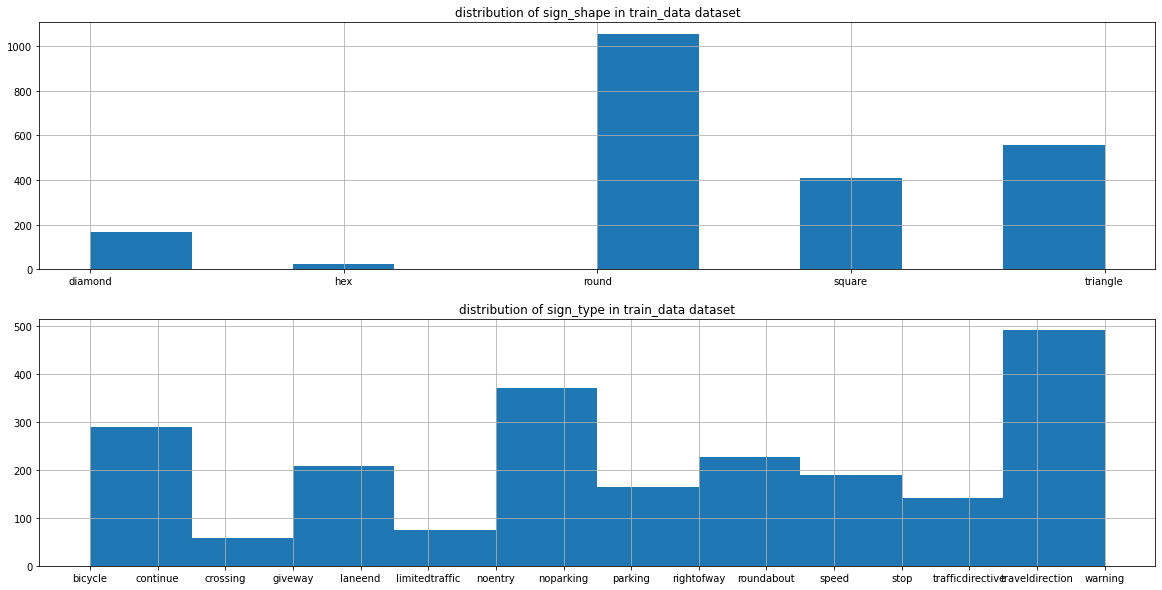

In [20]:
plot_distribution(train_data, "train_data")

**<u>Observation</u>:**

 * Shape data has 5 classes, while, sign data has 16 classes.
 * We can see that data imbalance appearing in both the shape dataset and sign dataset. <br>



## 1.5 **Labels encoding**



In this section we will use label encoder from sklearn to transform label into integer.

In [21]:
def label_encoder(dataframe):
  """
  This function is used to encode all the class from the provided dataframe into integer.
  :param dataframe: this is the input dataframe 
  """
  labelEncoder = LabelEncoder()
  if "sign_shape" in dataframe:
    dataframe.sign_shape = labelEncoder.fit_transform(dataframe.sign_shape)
  if "sign_type" in dataframe:
    dataframe.sign_type = labelEncoder.fit_transform(dataframe.sign_type)

In [22]:
label_encoder(train_data)
# Validate encoding on train data
train_data.head()

,image_path,sign_shape,sign_type
0,./train_test/train/diamond/rightofway/01528_00...,0,9
1,./train_test/train/diamond/rightofway/01511_00...,0,9
2,./train_test/train/diamond/rightofway/01673_00...,0,9
3,./train_test/train/diamond/rightofway/01243_00...,0,9
4,./train_test/train/diamond/rightofway/01511_00...,0,9


In [23]:
label_encoder(val_data)
# Validate encoding on validation data
val_data.head()

,image_path,sign_shape,sign_type
0,./train_test/val/diamond/rightofway/01526_0000...,0,9
1,./train_test/val/diamond/rightofway/01715_0000...,0,9
2,./train_test/val/diamond/rightofway/00118_0000...,0,9
3,./train_test/val/diamond/rightofway/01002_0000...,0,9
4,./train_test/val/diamond/rightofway/01249_0000...,0,9


In [24]:
label_encoder(test_data)
# Validate encoding on test data
test_data.head()

,image_path,sign_shape,sign_type
0,./train_test/test/diamond/rightofway/01263_000...,0,9
1,./train_test/test/diamond/rightofway/00930_000...,0,9
2,./train_test/test/diamond/rightofway/01013_000...,0,9
3,./train_test/test/diamond/rightofway/01275_000...,0,9
4,./train_test/test/diamond/rightofway/01244_000...,0,9


## 1.6 **Data Augmentation**

Acknowledging that our data is imbalance, we would want to experiment, later on,  if adding augmented data to smaller classes would improve the accuracy of the trained model. 

In this section we will create new folders that contain these new augmented dataset from the original training dataset. 

In [25]:
def create_augmented_folder(first_run):
  """
  This function is used to create augmented dataset folder.
  :param first_run: (boolean) this is set to True if this is the first runtime 
  """
  if first_run is False:
  # Use these two code to remove these augmented folders if no longer need
    shutil.rmtree(r'./augmented_shape')      
    shutil.rmtree(r'./augmented_type') 

  src = '/content/train_test/train'

  # create folder for shape
  dest1 = '/content/augmented_shape/train'

  # create folder for type
  dest2 = '/content/augmented_type/train'

  # copy
  shutil.copytree(src, dest1)
  shutil.copytree(src, dest2)



In [26]:
create_augmented_folder(first_run = True) # Set parameter to True if it is the first time running this notebook     

In [27]:
def img_augmentation(folder_path, limit):
    """
    This function apply rotation, flip, and alter brightness onto those images provided in the folder_path
    :param folder_path: (str) folder that data will be augmented
    :param limit: (int) the limit number that a number will be altered
    """
    image_list = []
    path = folder_path + '/*.png'
    print(path)
    
    for image in glob.glob(path, recursive=True):
        # read image
        img =  mpimg.imread(image )
        img_arr = img_to_array(img)
        img_arr = img_arr.reshape((1,) + img_arr.shape)
        # add to list
        image_list.append(img_arr)
        
    datagen = ImageDataGenerator(
    rotation_range = 20,
    shear_range = 0.2,
    zoom_range= 0.2,
    horizontal_flip = True,
    vertical_flip = True,
    brightness_range = (0.5, 1.5)
    )
              
    for img in image_list:
        i = 0
        for batch in datagen.flow(
                                    img ,
                                    batch_size=1,
                                    save_to_dir= folder_path,
                                    save_prefix = "Augment_image",
                                    save_format = 'png'
                                    ):
            i = i+1
            if i>limit: 
              break    

### 1.6.1 Shape Data Augmentation


In [28]:
# generate new image for shape
img_augmentation('./augmented_shape/train/diamond/rightofway', 4)
img_augmentation('./augmented_shape/train/hex/stop', 38)
img_augmentation('./augmented_shape/train/square/laneend', 1)
img_augmentation('./augmented_shape/train/square/parking', 1)
img_augmentation('./augmented_shape/train/square/continue', 1)
img_augmentation('./augmented_shape/train/triangle/giveway', 1)

./augmented_shape/train/diamond/rightofway/*.png
./augmented_shape/train/hex/stop/*.png
./augmented_shape/train/square/laneend/*.png
./augmented_shape/train/square/parking/*.png
./augmented_shape/train/square/continue/*.png
./augmented_shape/train/triangle/giveway/*.png


In [29]:
# put in data frame, encode, plot
augmented_data_shape = file_path_into_dataframe('./augmented_shape/train/*/*/*.png')
del augmented_data_shape["sign_type"]
augmented_data_shape.head()

,image_path,sign_shape
0,./augmented_shape/train/diamond/rightofway/Aug...,diamond
1,./augmented_shape/train/diamond/rightofway/Aug...,diamond
2,./augmented_shape/train/diamond/rightofway/Aug...,diamond
3,./augmented_shape/train/diamond/rightofway/Aug...,diamond
4,./augmented_shape/train/diamond/rightofway/015...,diamond


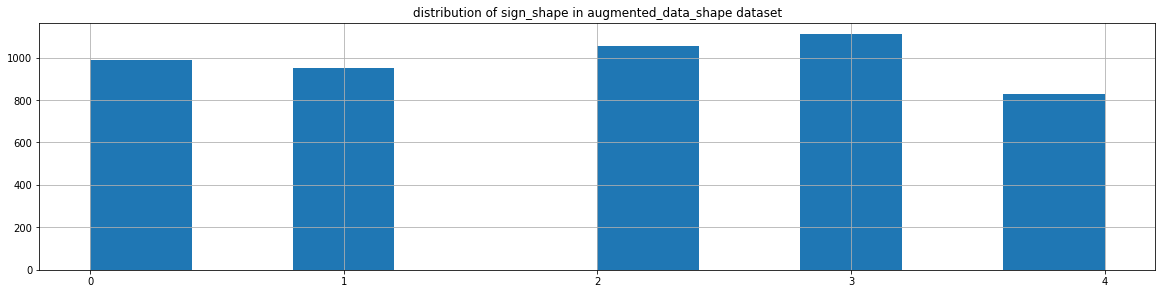

In [30]:
label_encoder(augmented_data_shape)
plot_distribution(augmented_data_shape, "augmented_data_shape")

### 1.6.2 Type Data Augmentation

In [31]:
# generate new data
img_augmentation('./augmented_type/train/square/continue', 1)
img_augmentation('./augmented_type/train/square/crossing', 5)
img_augmentation('./augmented_type/train/triangle/giveaway', 9)
img_augmentation('./augmented_type/train/square/laneend', 2)
img_augmentation('./augmented_type/train/round/limitedtraffic', 4)
img_augmentation('./augmented_type/train/square/parking', 1)
img_augmentation('./augmented_type/train/diamond/rightofway', 1)
img_augmentation('./augmented_type/train/round/speed',1)
img_augmentation('./augmented_type/train/hex/stop', 1)
img_augmentation('./augmented_type/train/round/trafficdirective', 1)

./augmented_type/train/square/continue/*.png
./augmented_type/train/square/crossing/*.png
./augmented_type/train/triangle/giveaway/*.png
./augmented_type/train/square/laneend/*.png
./augmented_type/train/round/limitedtraffic/*.png
./augmented_type/train/square/parking/*.png
./augmented_type/train/diamond/rightofway/*.png
./augmented_type/train/round/speed/*.png
./augmented_type/train/hex/stop/*.png
./augmented_type/train/round/trafficdirective/*.png


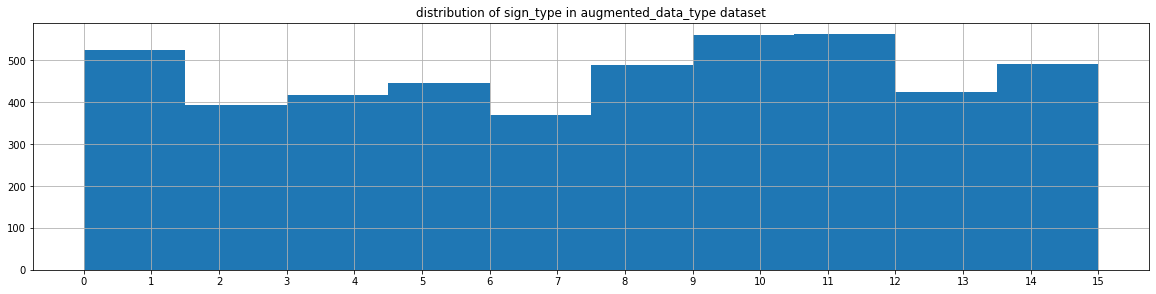

In [32]:
augmented_data_type = file_path_into_dataframe('./augmented_type/train/*/*/*.png')
label_encoder(augmented_data_type)
del augmented_data_type["sign_shape"]
plot_distribution(augmented_data_type, "augmented_data_type")

# **2. Model Development**
* **Goal**: Implementing and comparing the performance of MLP and CNN model. 
* **Setup the experiment**: We will be using 60% of the original dataset as training data, 20% for validating and 20% of the data to test (unseen data). 


## **2.1 Generating data**

### **Data Generator Utils**

All the functions that will be repeately used throughout `section 2.1 Generating Data` will be included in this section.

In [33]:
# Checking the shape of train dataset and validation dataset again
train_data.shape, val_data.shape

((2214, 3), (735, 3))

In [34]:
def to_grayscale(image):
    """
    This function is used to preprocess image and convert to grayscale
    :param image: image that will be preprocessed
    """
    image = tf.image.rgb_to_grayscale(image)
    return image

In [35]:
def generating_data_from_dataframe(dataframe, target, preprocessing_function = None, test = False):
    """
    This function is used to convert the refering target_column_name into string array and generate actual data from dataframe.
    :param dataframe: dataframe that data will be generated from
    :param target: (str) column of dataframe that data will be generated from
    :param test: (boolean) True if data generate is for a test set then apply params shuffle = False 
    """
    dataframe.loc[:,target] = dataframe.loc[:,target].astype('str')
    if preprocessing_function is None:
      generator = ImageDataGenerator(rescale = 1./255, data_format = 'channels_last')
    else: 
      generator = ImageDataGenerator(rescale = 1./255, data_format = 'channels_last', preprocessing_function = to_grayscale)
    batch_size = 32
    if test == False:
      data_gen = generator.flow_from_dataframe(
                                                dataframe = dataframe,
                                                directory = './',
                                                x_col = "image_path",
                                                y_col = target,
                                                target_size = (28, 28),
                                                batch_size = batch_size,
                                                class_mode = 'categorical')
    else:
      data_gen = generator.flow_from_dataframe(
                                                  dataframe = dataframe,
                                                  directory = './',
                                                  x_col = "image_path",
                                                  y_col = target,
                                                  target_size = (28, 28),
                                                  batch_size = batch_size,
                                                  class_mode = 'categorical',
                                                  shuffle = False)
    return data_gen
        

### **2.1.1 Shape Data**

In [36]:
# generate data for train & validation
train_shape = generating_data_from_dataframe(train_data, "sign_shape")
validation_shape = generating_data_from_dataframe(val_data, "sign_shape")


Found 2214 validated image filenames belonging to 5 classes.
Found 735 validated image filenames belonging to 5 classes.


### **2.1.2 Type Data**

In [37]:
# generate data for train & validation
train_type = generating_data_from_dataframe(train_data, "sign_type")
validation_type = generating_data_from_dataframe(val_data, "sign_type")


Found 2214 validated image filenames belonging to 16 classes.
Found 735 validated image filenames belonging to 16 classes.


### **2.1.3 Augmented Shape Data**

In [38]:
# generate data for augmented_shape dataset 
augmented_train_shape = generating_data_from_dataframe(augmented_data_shape, "sign_shape")

Found 4929 validated image filenames belonging to 5 classes.


### **2.1.4 Augmented Type Data**

In [39]:
# generate data for augmented_type dataset
augmented_train_type = generating_data_from_dataframe(augmented_data_type, "sign_type")

Found 4677 validated image filenames belonging to 16 classes.


## **2.2 Model Development**

### **Model Development Utils**

All the functions that will be repeately used throughout `section 2.2 Model Development` will be included in this section.

In [40]:
input_dimension = (28,28,3)
numbers_of_shape = len(train_data.sign_shape.unique())
numbers_of_sign = len(train_data.sign_type.unique())

In [41]:
early_stopping = tf.keras.callbacks.EarlyStopping(
                      monitor="val_loss",
                      min_delta=0.0001,
                      patience=15,
                      verbose=1,
                      mode="auto",
                      baseline=None,
                      restore_best_weights=True,
                  )

In [42]:
def plot_learning_curve(train_loss, val_loss, train_metric, val_metric, metric_name='Accuracy'):
    """
    This function is used to plot the learning curve between traing data and validation data.
    """

    plt.figure(figsize=(10,5))
    
    plt.subplot(1,2,1)
    plt.plot(train_loss, 'r--')
    plt.plot(val_loss, 'b--')
    plt.xlabel("epochs")
    plt.ylabel("Loss")
    plt.legend(['train', 'val'], loc='upper left')

    plt.subplot(1,2,2)
    plt.plot(train_metric, 'r--')
    plt.plot(val_metric, 'b--')
    plt.xlabel("epochs")
    plt.ylabel(metric_name)
    plt.legend(['train', 'val'], loc='upper left')

    plt.show()

In [43]:
# calculate class weights to solve the imbalance class problem
class_weights_shape = class_weight.compute_class_weight('balanced',
                                                 classes = train_data.sign_shape.unique(),
                                                 y = train_data.sign_shape.to_numpy())
# convert to dict format
class_weight_dict_shape = dict()
i = 0
for w in class_weights_shape:
    class_weight_dict_shape[i] = w
    i= i+1


In [44]:
# calculate class weights
class_weights_sign = class_weight.compute_class_weight('balanced',
                                                 classes = train_data.sign_type.unique(),
                                                 y = train_data.sign_type.to_numpy())
# convert to dict format
class_weight_dict_sign = dict()
i = 0
for w in class_weights_sign:
    class_weight_dict_sign[i] = w
    i= i+1

### **2.2.1 Multilayer Perceptrons Network**

Our base model for multilayer perceptrons networks consists of 3 layers, inlcuding a flatten layer, a hidden lense layer and a output dense layer.

The aim of this section would be to evaluate the performance of this architecture on the validation set and modify this architecture accordingly to observations so as to improve accuracy, convergent time as well as reducing overfit/underfit.

#### **2.2.1.1 Shape Classification**

###### **2.2.1.1.1. Base Model**

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


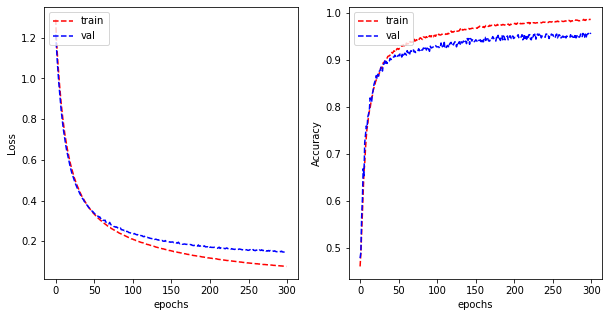

In [45]:
# build model
base_model_mpl_shape = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=input_dimension),
    tf.keras.layers.Dense(32, activation='sigmoid'),
    tf.keras.layers.Dense(numbers_of_shape, activation ='softmax')
])
# comile model
base_model_mpl_shape.compile(optimizer='SGD',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])
# train model
history = base_model_mpl_shape.fit_generator(train_shape, validation_data = validation_shape, epochs=300, verbose=0)
# plot 
plot_learning_curve(history.history['loss'], history.history['val_loss'], 
                    history.history['categorical_accuracy'], history.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

<u>Observation:</u><br>
* The model does not need 300 epochs to converges. 
* The accuracies of train and validation are around 92% at convergent point.
* Overfitting starts to occur after 50 epochs where performance on train set showed to be much better than validation set.


<u>Actions:</u><br>
Although the accuracy is quite good, our aim is to test whether higher accuracy is achieveable as well as whether the model can converge faster.
We would also need to solve the problem of overfitting.
For this reason, we will tune certain parameters.

In [46]:
base_model_mpl_shape.save("shape_based_MLP_model")     
!cp -R ./shape_based_MLP_model /content/gdrive/'My Drive'/COSC2673_2110/   

INFO:tensorflow:Assets written to: shape_based_MLP_model/assets


###### **2.2.1.1.2 Parameters Tuning Model**

***Class Weight***

Since we have an imbalanced dataset, we will try to include the `class_weight` parameters with the weights being the number of items available in  one class. This is one way of improving the accuracy of the model without the need to change the model architecture.



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


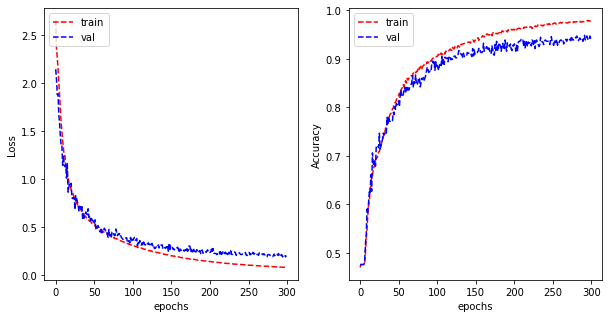

In [47]:
# build model
base_model_mpl_shape_with_classweight = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=input_dimension),
    tf.keras.layers.Dense(32, activation='sigmoid'),
    tf.keras.layers.Dense(numbers_of_shape, activation ='softmax')
])
# comile model
base_model_mpl_shape_with_classweight.compile(optimizer='SGD',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])
# train model
history = base_model_mpl_shape_with_classweight.fit_generator(train_shape, validation_data = validation_shape, class_weight=class_weight_dict_shape,  epochs=300, verbose=0)
# plot 
plot_learning_curve(history.history['loss'], history.history['val_loss'], 
                    history.history['categorical_accuracy'], history.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')


<u>Observation:</u><br>
* Although `class_weight` parameter is included, the accuracy of the model is not much higher comparing to the baseline one. 


<u>Actions:</u><br>
* We would want to change the architecture and see whether the accuracy would be improved.
* Firstly we would test whether increase the number of neurons in one hidden layer will improve the accuracy.


***Adding Neurons to Hidden Layer***

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  from ipykernel import kernelapp as app


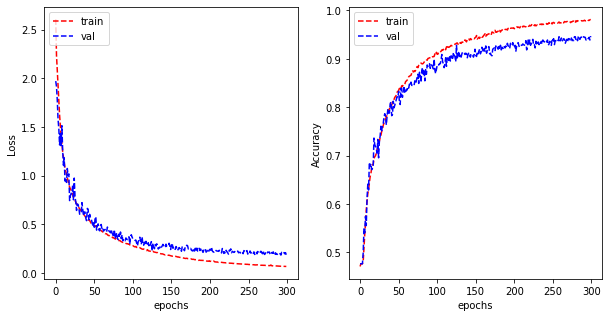

In [48]:
# Increase the number of neurons in the 1st hidden layer
model_mlp2_shape = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=input_dimension),
    # 1st layer
    tf.keras.layers.Dense(128, activation = "sigmoid"),
    tf.keras.layers.Dense(numbers_of_shape, activation='softmax' )
])

    # loss function
model_mlp2_shape.compile(optimizer=keras.optimizers.SGD(),
                 loss='CategoricalCrossentropy',
                 metrics=['categorical_accuracy'])

# feed data to model
history = model_mlp2_shape.fit_generator(train_shape, validation_data = validation_shape, epochs=300, verbose=0,class_weight=class_weight_dict_shape)
#plot
plot_learning_curve(history.history['loss'], history.history['val_loss'], 
                    history.history['categorical_accuracy'], history.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')


<u>Observation:</u><br>
* The accuracy is slightly higher (around 1%), as expected, when we increase the number of neurons in the hidden layer.
* The 2 models converge at similar rate, however, overfit problem occurs much earlier comparing to the previous model. 


<u>Actions:</u><br>
* We will test adding another hidden layer and expect the accuracy will further be improve.


***Adding Hidden Layer***

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


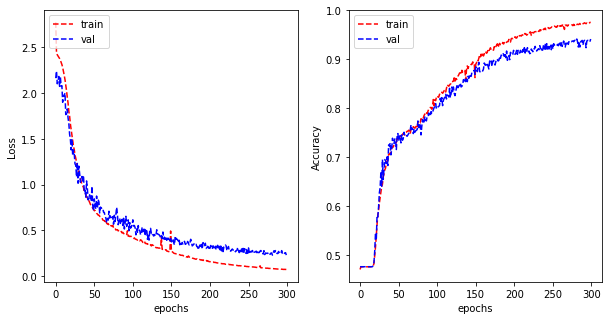

In [49]:
# increase the number of hidden layers 
model_mlp3_shape = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=input_dimension),
    # 1st layer
    tf.keras.layers.Dense(128, activation = "sigmoid"),
    # 2nd layer
    tf.keras.layers.Dense(128, activation = "sigmoid")  ,
    tf.keras.layers.Dense(numbers_of_shape, activation='softmax' )
])

    # loss function
model_mlp3_shape.compile(optimizer=keras.optimizers.SGD(),
                 loss='CategoricalCrossentropy',
                 metrics=['categorical_accuracy'])

# feed data to model
history = model_mlp3_shape.fit_generator(train_shape, validation_data = validation_shape, epochs=300, verbose=0,class_weight=class_weight_dict_shape)
#plot
plot_learning_curve(history.history['loss'], history.history['val_loss'], 
                    history.history['categorical_accuracy'], history.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')


<u>Observation:</u><br>
* The model shows to be slightly overfitted (around 2%), however, the accuracy does not increase as much as before. 
* It seems that the model has already reached an saturated level. 



<u>Actions:</u><br>
* It seems like using this same activation function `sigmoid` the model has already reached an saturation point where changing the model architecture no longer can improve the accuracy. For this reason we will test if we can improve the convergant rate by changing the activation to `relu`. 


***Relu Activation***

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  from ipykernel import kernelapp as app


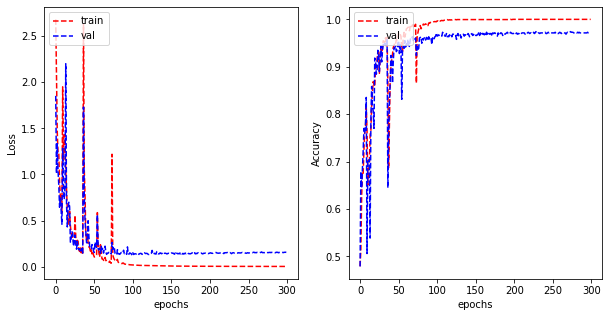

In [50]:
# Add normalization
model_mlp4_shape = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=input_dimension),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(128, activation = "relu")  ,
    tf.keras.layers.Dense(numbers_of_shape, activation='softmax' )
])

    # loss function
model_mlp4_shape.compile(optimizer=keras.optimizers.SGD(),
                 loss='CategoricalCrossentropy',
                 metrics=['categorical_accuracy'])

# feed data to model
history = model_mlp4_shape.fit_generator(train_shape, validation_data = validation_shape, epochs=300, verbose=0 ,class_weight=class_weight_dict_shape)

plot_learning_curve(history.history['loss'], history.history['val_loss'], 
                    history.history['categorical_accuracy'], history.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')



<u>Observation:</u><br>
* Convergent rate is much faster and accuracy is still very high.  
* When changing from `sigmoid` parameter to `relu` the model shows a similar overfit percentage (2% comparing to 1%) when training until convergent. 
* For this reason we will keep on improving the model using `relu` activation function instead of `sigmoid`. 



<u>Actions:</u><br>
* As overfit is oberved, we will apply certain technique trying to solve this problem. 
* Techniques that will be tested including `kernal_regulizer`, `dropout`, and `early_stopping`.  

***Ridge Regularization***

We will test 2 different alpha value which is 0.001 and 0.01 and compare their impacts on the model

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  from ipykernel import kernelapp as app


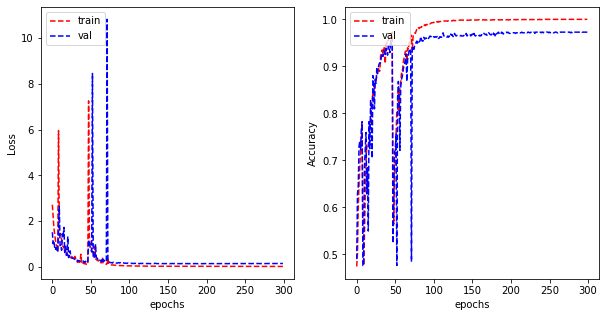

In [51]:
# regularisation
model_mlp5_shape = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=input_dimension),
    tf.keras.layers.Dense(128, activation = "relu", kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
    tf.keras.layers.Dense(128, activation = "relu"),
    tf.keras.layers.Dense(numbers_of_shape, activation='softmax')
])

    # loss function
model_mlp5_shape.compile(optimizer=keras.optimizers.SGD(),
                 loss='CategoricalCrossentropy',
                 metrics=['categorical_accuracy'])

# feed data to model
history = model_mlp5_shape.fit_generator(train_shape, validation_data = validation_shape, epochs=300, verbose=0,class_weight=class_weight_dict_shape)

plot_learning_curve(history.history['loss'], history.history['val_loss'], 
                    history.history['categorical_accuracy'], history.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  from ipykernel import kernelapp as app


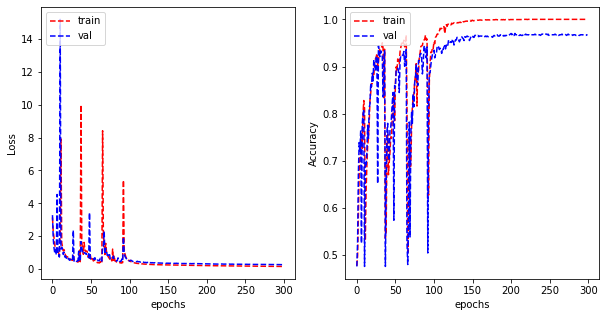

In [52]:
# regularisation
model_mlp6_shape = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=input_dimension),
    tf.keras.layers.Dense(128, activation = "relu", kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.Dense(128, activation = "relu"),
    tf.keras.layers.Dense(numbers_of_shape, activation='softmax')
])

    # loss function
model_mlp6_shape.compile(optimizer=keras.optimizers.SGD(),
                 loss='CategoricalCrossentropy',
                 metrics=['categorical_accuracy'])

# feed data to model
history = model_mlp6_shape.fit_generator(train_shape, validation_data = validation_shape, epochs=300, verbose=0,class_weight=class_weight_dict_shape)

plot_learning_curve(history.history['loss'], history.history['val_loss'], 
                    history.history['categorical_accuracy'], history.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')


<u>Observation:</u><br>
* Model seems to be less overfit when regularization is being used. 
* The model that used an alpha 0.001, however, shows more accuracy drops within the first few epochs when comparing to 0.0001. This means that an alpha of 0.001 is too large for this dataset as the higher this alpha coefficient, the higher the shrinkage.
* For this reason, we would want to keep the regularization of 0.0001.  



<u>Actions:</u><br>
* We would first further test out other technique to lower the overfit. The next techniques that will be applied are `dropout`, which will disable certain neurons during training, and `early_stopping`, which will stop training when validation accuracy stop improving.
* These two techniques do not work well together as `dropout` often reduces the accuracy of the model so it is better to have longer training epoch. For this reason, these two techniques will be used separately. 


***Dropout***

The technique has an effect of preventing weights from being overly dependent on each other.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  from ipykernel import kernelapp as app


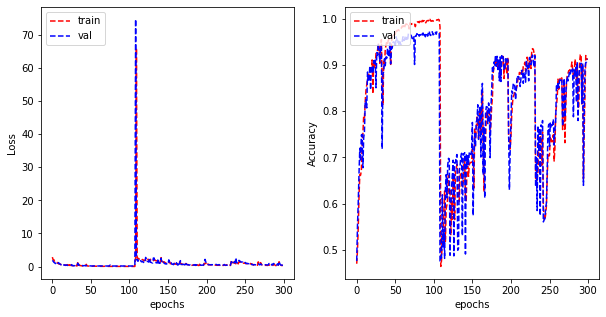

In [53]:
model_mlp7_shape = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=input_dimension),
    tf.keras.layers.Dense(128, activation = "relu", kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
    tf.keras.layers.Dense(128, activation = "relu"),
    tf.keras.layers.Dropout(.2),
    tf.keras.layers.Dense(numbers_of_shape, activation='softmax')
])

    # loss function
model_mlp7_shape.compile(optimizer=keras.optimizers.SGD(),
                 loss='CategoricalCrossentropy',
                 metrics=['categorical_accuracy'])

# feed data to model
history = model_mlp7_shape.fit_generator(train_shape, validation_data = validation_shape, epochs=300, verbose=0,class_weight=class_weight_dict_shape)

plot_learning_curve(history.history['loss'], history.history['val_loss'], 
                    history.history['categorical_accuracy'], history.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')



***Early Stopping***



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Restoring model weights from the end of the best epoch: 43.
Epoch 58: early stopping


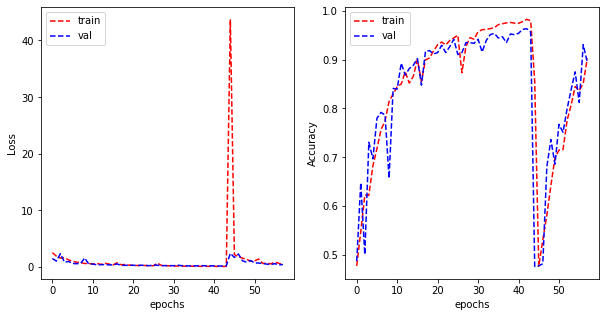

In [54]:
model_mlp8_shape = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=input_dimension),
    tf.keras.layers.Dense(128, activation = "relu", kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
    tf.keras.layers.Dense(128, activation = "relu"),
    tf.keras.layers.Dense(numbers_of_shape, activation='softmax')
])

    # loss function
model_mlp8_shape.compile(optimizer=keras.optimizers.SGD(),
                 loss='CategoricalCrossentropy',
                 metrics=['categorical_accuracy'])

# feed data to model
history = model_mlp8_shape.fit_generator(train_shape, validation_data = validation_shape, epochs=300, verbose=0,class_weight=class_weight_dict_shape, callbacks = [early_stopping])

plot_learning_curve(history.history['loss'], history.history['val_loss'], 
                    history.history['categorical_accuracy'], history.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')



<u>Observation:</u><br>
* Both models using `dropout` and `early_stopping` shows similar performance in term of accuracy and convergent. However, `early_stopping` is less overfit.
* We will save the model that use `early_stopping` to test on the test set.

In [55]:
model_mlp8_shape.save("shape_fine_tuned_MLP_model")     
!cp -R ./shape_fine_tuned_MLP_model /content/gdrive/'My Drive'/COSC2673_2110/      

INFO:tensorflow:Assets written to: shape_fine_tuned_MLP_model/assets


###### **2.2.1.1.3 Model for Augmented data for Shape (no class weight)**

We have created an augmented dataset in previous section which solved the problem of imbalanced by adding augmented data to smaller data class. 

We would want to try if using this new training set will improve the accuracy of the model on the test set.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Restoring model weights from the end of the best epoch: 46.
Epoch 61: early stopping


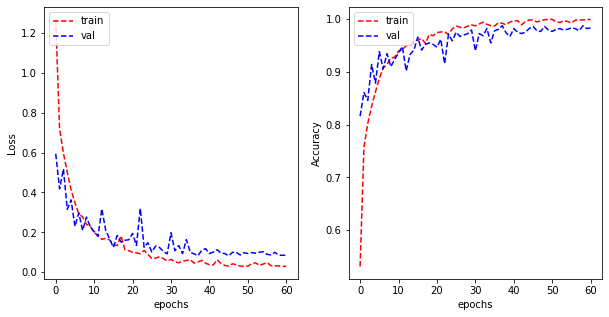

In [56]:
# regularisation
model_mlp_shape_augmented = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=input_dimension),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
    tf.keras.layers.LayerNormalization(),
    tf.keras.layers.Dense(128),
    tf.keras.layers.Dropout(.5),
    tf.keras.layers.Dense(numbers_of_shape, activation='softmax')
])

    # loss function
model_mlp_shape_augmented.compile(optimizer=keras.optimizers.SGD(),
                 loss='CategoricalCrossentropy',
                 metrics=['categorical_accuracy'])

# feed data to model
history = model_mlp_shape_augmented.fit_generator(augmented_train_shape, validation_data = validation_shape, epochs=300, verbose=0, callbacks = [early_stopping])

plot_learning_curve(history.history['loss'], history.history['val_loss'], 
                    history.history['categorical_accuracy'], history.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')


<u>Observation:</u><br>
* Comparing to the previous model, the accuracies for train and validation slightly decrease, however, the convergent rate is faster. 
* We want to test this model on the test set so this model would be saved.

In [57]:
model_mlp_shape_augmented.save("shape_model_mlp_augmented")     
!cp -R ./shape_model_mlp_augmented /content/gdrive/'My Drive'/COSC2673_2110/    

INFO:tensorflow:Assets written to: shape_model_mlp_augmented/assets


#### **2.2.1.2 Type Classification**


###### **2.2.1.2.1 Base Model**

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  # This is added back by InteractiveShellApp.init_path()


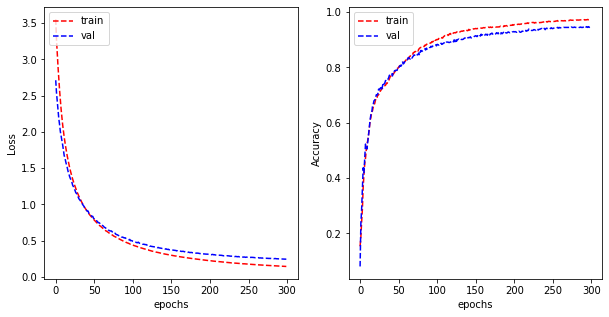

In [58]:
base_model_mlp_type = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=input_dimension),
    tf.keras.layers.Dense(64, activation='sigmoid'),
    tf.keras.layers.Dense(numbers_of_sign)
])

base_model_mlp_type.compile(optimizer='SGD',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])

history = base_model_mlp_type.fit_generator(train_type, validation_data=validation_type, epochs=300, verbose=0, class_weight=class_weight_dict_sign)


plot_learning_curve(history.history['loss'], history.history['val_loss'], 
                    history.history['categorical_accuracy'], history.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')



<u>Observation:</u><br>
* This base model performs quite well on both training set and validation set, however, we would want to achieve slightly higher accuracy. 
* We would first try to boost the model accuracy a bit further by adding more neurons and another hidden layer. Then, we will implement techniques to solve overfitting. 

In [59]:
base_model_mlp_type.save("sign_base_model_mlp")     
!cp -R ./sign_base_model_mlp /content/gdrive/'My Drive'/COSC2673_2110/    

INFO:tensorflow:Assets written to: sign_base_model_mlp/assets



##### **2.2.1.2.2 Parameters Tuning Model**



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


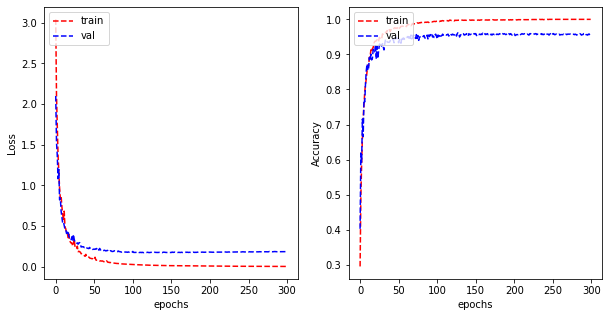

In [60]:
model_mlp1_type = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=input_dimension),
    tf.keras.layers.Dense(128, activation = "relu"),
    tf.keras.layers.Dense(128, activation = "relu"),
    tf.keras.layers.Dense(numbers_of_sign, activation='softmax')
])

    # loss function
model_mlp1_type.compile(optimizer=keras.optimizers.SGD(),
                 loss='CategoricalCrossentropy',
                 metrics=['categorical_accuracy'])

# feed data to model
history = model_mlp1_type.fit_generator(train_type, validation_data = validation_type, epochs=300, verbose=0,class_weight=class_weight_dict_sign)

plot_learning_curve(history.history['loss'], history.history['val_loss'], 
                    history.history['categorical_accuracy'], history.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')



<u>Observation:</u><br>
* We can see that by increasing the number of neurons and add 1 more layers the model now has been able to increase its accuracy by 2%, however, overfit is much larger comparing to the previous model. 
* We will try to solve the problem of overfitting so a combination of techniques including `regularization` and `early_stopping` will be used.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


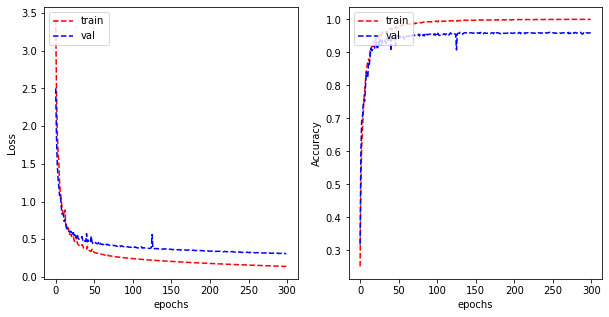

In [61]:
model_mlp2_type = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=input_dimension),
    tf.keras.layers.Dense(128, activation = "relu", kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.Dense(128, activation = "relu"),
    tf.keras.layers.Dense(numbers_of_sign, activation='softmax')
])

    # loss function
model_mlp2_type.compile(optimizer=keras.optimizers.SGD(),
                 loss='CategoricalCrossentropy',
                 metrics=['categorical_accuracy'])

# feed data to model
history = model_mlp2_type.fit_generator(train_type, validation_data = validation_type, epochs=300, verbose=0,class_weight=class_weight_dict_sign, callbacks = [early_stopping])

plot_learning_curve(history.history['loss'], history.history['val_loss'], 
                    history.history['categorical_accuracy'], history.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Restoring model weights from the end of the best epoch: 118.
Epoch 133: early stopping


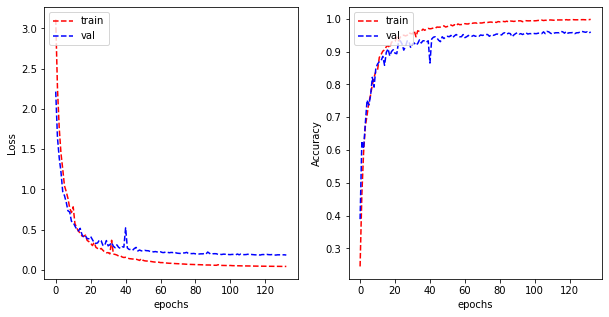

In [62]:
model_mlp3_type = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=input_dimension),
    tf.keras.layers.Dense(128, activation = "relu", kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
    tf.keras.layers.Dense(128, activation = "relu"),
    tf.keras.layers.Dense(numbers_of_sign, activation='softmax')
])

    # loss function
model_mlp3_type.compile(optimizer=keras.optimizers.SGD(),
                 loss='CategoricalCrossentropy',
                 metrics=['categorical_accuracy'])

# feed data to model
history = model_mlp3_type.fit_generator(train_type, validation_data = validation_type, epochs=300, verbose=0,class_weight=class_weight_dict_sign, callbacks = [early_stopping])

plot_learning_curve(history.history['loss'], history.history['val_loss'], 
                    history.history['categorical_accuracy'], history.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')



<u>Observation:</u><br>
* In model 2, a regularization of 0.0001 is used, while in model 3, a regularization of 0.001 is used. 
* These 2 models show similar level of overfit and accuracy is also not much different. We will save model 3 to test with the test set.

In [63]:
model_mlp3_type.save("sign_fine_tuned_MLP_model")     
!cp -R ./sign_fine_tuned_MLP_model /content/gdrive/'My Drive'/COSC2673_2110/    

INFO:tensorflow:Assets written to: sign_fine_tuned_MLP_model/assets



##### **2.2.1.2.3 Model for augmented data for type (no class weight)**

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  from ipykernel import kernelapp as app


Restoring model weights from the end of the best epoch: 54.
Epoch 69: early stopping


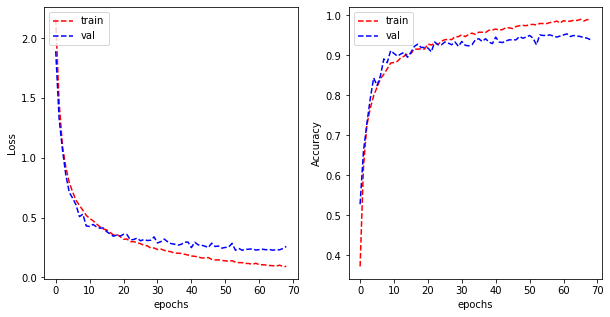

In [64]:
# regularisation
model_mpl_augmented_type= tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=input_dimension),
    tf.keras.layers.Dense(128, activation = "relu", kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
    tf.keras.layers.Dense(128, activation = "relu"),
    tf.keras.layers.Dense(numbers_of_sign, activation='softmax' )
])

    # loss function
model_mpl_augmented_type.compile(optimizer=keras.optimizers.SGD(),
                 loss='CategoricalCrossentropy',
                 metrics=['categorical_accuracy'])

# feed data to model
history = model_mpl_augmented_type.fit_generator(augmented_train_type, validation_data = validation_type, epochs=300, verbose=0,callbacks = [early_stopping])

plot_learning_curve(history.history['loss'], history.history['val_loss'], 
                    history.history['categorical_accuracy'], history.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')



<u>Observation:</u><br>
* The augmented data is used to train the model.
* The accuracies of train and validation decreased but the convergent is faster comparing to the previous model, and model is overfitted with an increasing of the gap between train and validation data.

In [65]:
model_mpl_augmented_type.save("sign_model_mpl_augmented")     
!cp -R ./sign_model_mpl_augmented /content/gdrive/'My Drive'/COSC2673_2110/    

INFO:tensorflow:Assets written to: sign_model_mpl_augmented/assets


### **2.2.2 Convolution Neural Network**

In this section, we will implement two popular CNN architectural namely VGG and LeNet as our baseline model. Depending on the result, we will configure the architecture so as to be able to figure out the best solution for this image classification problem.

#### **A. VGG CNN Baseline Model**


The VGG architecture that was used as the baseline model for this project is the modified architecture that was provided in the lecture (**link**). 

This modified architecture was chosen over the original VGG architecture as the original one contains many VGG - block (convolution + activation + pooling) and it is more suitable for larger image, however, our image is only of 28 * 28, which makes the modified version preferable. 

In [66]:
def create_VGG_Model(output):
  """
  This function is used to create a VGG model.
  :param output: the shape of the output
  """
  VGG_model = tf.keras.Sequential([
      # Block 1
      tf.keras.layers.Conv2D(28, (3, 3), activation='relu', padding='same', input_shape=input_dimension),
      tf.keras.layers.Conv2D(28, (3, 3), activation='relu', padding='same'),
      tf.keras.layers.MaxPooling2D((2, 2)),
      
      # Block 2
      tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
      tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
      tf.keras.layers.MaxPooling2D((2, 2)),
      
      # Block 3
      tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
      tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
      tf.keras.layers.MaxPooling2D((2, 2)),
      
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(128, activation='relu'),
      tf.keras.layers.Dense(output, activation = "softmax"),
      ])
  VGG_model.summary()
  return VGG_model

#### **B. LeNet CNN Baseline Model**

In [67]:
def create_LeNet_model(output):
  """
  This function is used to create a LeNet model.
  :param output: the shape of the output
  """
  reg_lambda = 0.001

  LeNet_model = tf.keras.Sequential([
      tf.keras.layers.Input(shape=input_dimension),
      tf.keras.layers.Lambda(lambda x: tf.expand_dims(x[:,:,:,0], -1, name=None)),
      
      
      tf.keras.layers.Conv2D(32, (3, 3), kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
      tf.keras.layers.Activation('relu'),
      tf.keras.layers.MaxPool2D(pool_size=(2,2)),
      
      tf.keras.layers.Conv2D(32, (3, 3), kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
      tf.keras.layers.Activation('relu'),
      
      tf.keras.layers.Conv2D(64, (3, 3)),
      tf.keras.layers.Activation('relu'),
      tf.keras.layers.MaxPool2D(pool_size=(2,2)),
      
      tf.keras.layers.Flatten(),
      
      tf.keras.layers.Dense(64),
      tf.keras.layers.Activation('relu'),
      tf.keras.layers.Dropout(0.5),
      tf.keras.layers.Dense(output, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda))
  ])
  return LeNet_model



#### **2.2.2.1 Shape Classification**

##### 2.2.2.1.1 VGG Base

In [68]:
VGG_model_shape = create_VGG_Model(numbers_of_shape)

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 28)        784       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 28)        7084      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 28)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 64)        16192     
                                                                 
 conv2d_3 (Conv2D)           (None, 14, 14, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  if __name__ == '__main__':


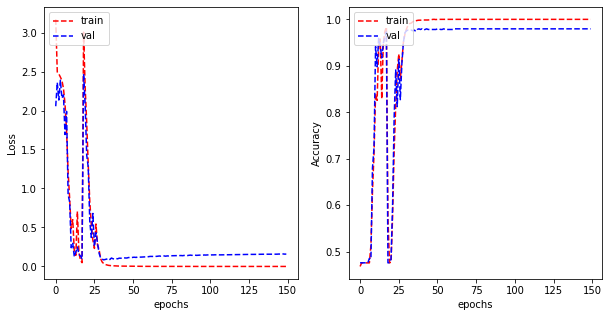

In [69]:
VGG_model_shape.compile(
              # Use sgd over adam as our dataset is not very large so we care more about generalized
              # adam would be better in case we need the data to be able to converge faster
              optimizer = 'sgd',
              # Use categorical_crossentropy instead of sparse as we use one hot label encoder
              loss = "categorical_crossentropy",     
              metrics = ['categorical_accuracy'])
  
history = VGG_model_shape.fit_generator(train_shape, validation_data = validation_shape, epochs=150, class_weight=class_weight_dict_shape, verbose=0)
  
plot_learning_curve(history.history['loss'], history.history['val_loss'], 
                    history.history['categorical_accuracy'], history.history['val_categorical_accuracy'], 
                    metric_name = 'Accuracy')

**Observations:**
- Although the model has high accuracy it seems like the model is still overfit. 
- One of the reason for this is that, in the base architecture of VGG that was used, regularization and dropout has not been implemented. In the next sections, these 2 techniques to solve overfitting will be implemented. 

In [70]:
VGG_model_shape.save("shape_VGG_base_model")     
!cp -R ./shape_VGG_base_model /content/gdrive/'My Drive'/COSC2673_2110/        

INFO:tensorflow:Assets written to: shape_VGG_base_model/assets


##### 2.2.2.1.2 LeNet Base

In [71]:
LeNet_model_shape = create_LeNet_model(numbers_of_shape)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  if sys.path[0] == '':


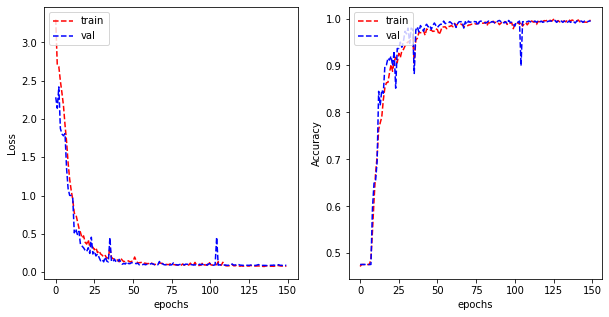

In [72]:
LeNet_model_shape.compile(
              # Use sgd over adam as our dataset is not very large so we care more about generalized
              # adam would be better in case we need the data to be able to converge faster
              optimizer = 'sgd',
              # Use categorical_crossentropy instead of sparse as we use one hot label encoder
              loss = "categorical_crossentropy",     
              metrics = ['categorical_accuracy'])
  
# Early stopping is included to prevent long training time
# Training will be interupt if there is no further improvement in validation set
# restore_best_weights arguement is used to return the model to the best model
history = LeNet_model_shape.fit_generator(train_shape, validation_data = validation_shape, epochs=150, class_weight=class_weight_dict_shape, verbose=0)
  
plot_learning_curve(history.history['loss'], history.history['val_loss'], 
                    history.history['categorical_accuracy'], history.history['val_categorical_accuracy'], 
                    metric_name = 'Accuracy')

In [73]:
LeNet_model_shape.save("shape_LeNet_base_model")
!cp -R ./shape_LeNet_base_model /content/gdrive/'My Drive'/COSC2673_2110/

INFO:tensorflow:Assets written to: shape_LeNet_base_model/assets


##### **2.2.2.1.3 L2 Regularization (tuning regularization lambda)**

In [74]:
def parameters(reg_lambda, output):
    VGG_model_with_regularization = tf.keras.Sequential([
    # Block 1
    tf.keras.layers.Conv2D(28, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer = tf.keras.regularizers.L2(reg_lambda), input_shape=input_dimension),
    tf.keras.layers.Conv2D(28, (3, 3), activation='relu', padding='same',
                           kernel_regularizer= tf.keras.regularizers.L2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    # Block 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same',
                           kernel_regularizer=tf.keras.regularizers.L2(reg_lambda)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same',
                                  kernel_regularizer=tf.keras.regularizers.L2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    # Block 3
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same',
                           kernel_regularizer=tf.keras.regularizers.L2(reg_lambda)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.L2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(reg_lambda)),
    tf.keras.layers.Dense(output, activation = "softmax"),
    ])

    VGG_model_with_regularization.compile(
              # Use sgd over adam as our dataset is not very large so we care more about generalized
              # adam would be better in case we need the data to be able to converge faster
              optimizer = 'sgd',
              # Use categorical_crossentropy instead of sparse as we use one hot label encoder
              loss = "categorical_crossentropy",     
              metrics = ['categorical_accuracy'])
  
    return VGG_model_with_regularization
  
  
def build_model_VGG_l2_regular_shape(hp):
    """
    This function is used to tune the regularization lambda value.
    """
    reg_lambda = hp.Choice('reg_lambda', [0.001, 0.01, 0.1])  # the best value between these 3 will be chose.
    model = parameters(reg_lambda, numbers_of_shape)
    return model

build_model_VGG_l2_regular_shape(kt.HyperParameters())

In [75]:
tuner_reg_l2_shape = kt.RandomSearch(
    build_model_VGG_l2_regular_shape,
    objective='val_loss',
    max_trials=3,
    overwrite = True)
tuner_reg_l2_shape.search_space_summary()

Search space summary
Default search space size: 1
reg_lambda (Choice)
{'default': 0.001, 'conditions': [], 'values': [0.001, 0.01, 0.1], 'ordered': True}


In [76]:
tuner_reg_l2_shape.search(train_shape, epochs= 150, verbose = 0, validation_data=validation_shape, class_weight=class_weight_dict_shape)

INFO:tensorflow:Oracle triggered exit


In [77]:
tuner_reg_l2_shape.results_summary()

Results summary
Results in ./untitled_project
Showing 10 best trials
Trial summary
Hyperparameters:
reg_lambda: 0.01
Score: 0.36475467681884766
Trial summary
Hyperparameters:
reg_lambda: 0.001
Score: 0.45403945446014404
Trial summary
Hyperparameters:
reg_lambda: 0.1
Score: 2.1108651161193848


In [78]:
# get best model and best hyper parameter
best_model = tuner_reg_l2_shape.get_best_models()[0]
best_hp = tuner_reg_l2_shape.get_best_hyperparameters()[0]
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 28)        784       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 28)        7084      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 28)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 64)        16192     
                                                                 
 conv2d_3 (Conv2D)           (None, 14, 14, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                    

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


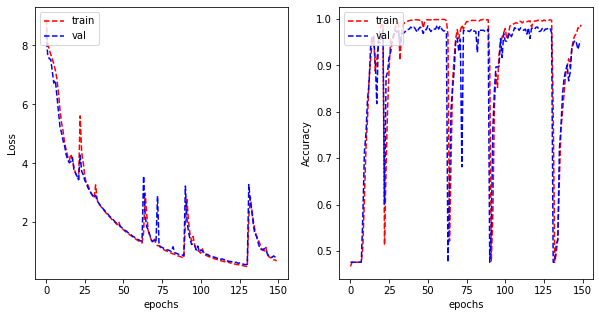

In [79]:
# Retrain the best model and plot validation
model_VGG_best_regularization_l2_shape = tuner_reg_l2_shape.hypermodel.build(best_hp)
history = model_VGG_best_regularization_l2_shape.fit_generator(train_shape, validation_data = validation_shape, epochs=150, verbose=0, class_weight=class_weight_dict_shape)
  
plot_learning_curve(history.history['loss'], history.history['val_loss'], 
                    history.history['categorical_accuracy'], history.history['val_categorical_accuracy'], 
                    metric_name = 'Accuracy')

**Observations:**
- The model shows to be much less overfit when regularization is applied. However, we still want to try if we can keep the two data closer and comparable with LeNet architecture.
- We do this by keeping the best value of l2 which is 0.01 and then applied `dropout_rate` on it. We will test 2 values of `dropout_rate` which is 0.2 and 0.5

##### **2.2.2.1.4 Dropout regularization (tuning dropout rate)**

In [80]:
reg_lambda = 0.01
dropout_rate = 0.5

VGG_model_with_regularization_with_dropout_05 = tf.keras.Sequential([
  # Block 1
  tf.keras.layers.Conv2D(28, (3, 3), activation='relu', padding='same', 
                          kernel_regularizer = tf.keras.regularizers.l2(reg_lambda), input_shape=input_dimension),
  tf.keras.layers.Conv2D(28, (3, 3), activation='relu', padding='same',
                          kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
  tf.keras.layers.MaxPooling2D((2, 2)),
  
  # Block 2
  tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same',
                          kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
  tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same',
                                kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
  tf.keras.layers.MaxPooling2D((2, 2)),
  
  # Block 3
  tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same',
                          kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
  tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', 
                          kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
  tf.keras.layers.MaxPooling2D((2, 2)),
  
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
  tf.keras.layers.Dropout(rate = dropout_rate),
  tf.keras.layers.Dense(numbers_of_shape, activation = "softmax"),
  ])

VGG_model_with_regularization_with_dropout_05.compile(
          # Use sgd over adam as our dataset is not very large so we care more about generalized
          # adam would be better in case we need the data to be able to converge faster
          optimizer = 'sgd',
          # Use categorical_crossentropy instead of sparse as we use one hot label encoder
          loss = "categorical_crossentropy",     
          metrics = ['categorical_accuracy'])
  
  



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """Entry point for launching an IPython kernel.


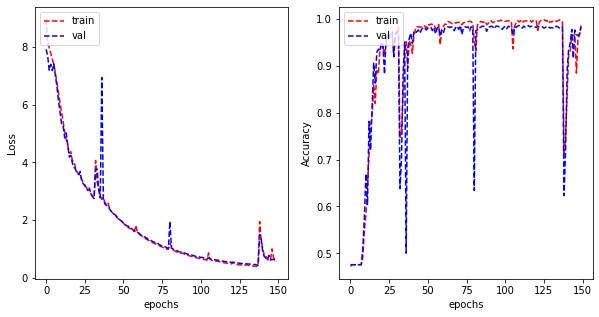

In [81]:
history = VGG_model_with_regularization_with_dropout_05.fit_generator(train_shape, validation_data = validation_shape, epochs=150, verbose=0, class_weight=class_weight_dict_shape)
  
plot_learning_curve(history.history['loss'], history.history['val_loss'], 
                    history.history['categorical_accuracy'], history.history['val_categorical_accuracy'], 
                    metric_name = 'Accuracy')

In [82]:
reg_lambda = 0.001
dropout_rate = 0.2

VGG_model_with_regularization_with_dropout_02 = tf.keras.Sequential([
  # Block 1
  tf.keras.layers.Conv2D(28, (3, 3), activation='relu', padding='same', 
                          kernel_regularizer = tf.keras.regularizers.l2(reg_lambda), input_shape=input_dimension),
  tf.keras.layers.Conv2D(28, (3, 3), activation='relu', padding='same',
                          kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
  tf.keras.layers.MaxPooling2D((2, 2)),
  
  # Block 2
  tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same',
                          kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
  tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same',
                                kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
  tf.keras.layers.MaxPooling2D((2, 2)),
  
  # Block 3
  tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same',
                          kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
  tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', 
                          kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
  tf.keras.layers.MaxPooling2D((2, 2)),
  
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
  tf.keras.layers.Dropout(rate = dropout_rate),
  tf.keras.layers.Dense(numbers_of_shape, activation = "softmax"),
  ])

VGG_model_with_regularization_with_dropout_02.compile(
          # Use sgd over adam as our dataset is not very large so we care more about generalized
          # adam would be better in case we need the data to be able to converge faster
          optimizer = 'sgd',
          # Use categorical_crossentropy instead of sparse as we use one hot label encoder
          loss = "categorical_crossentropy",     
          metrics = ['categorical_accuracy'])
  
  



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """Entry point for launching an IPython kernel.


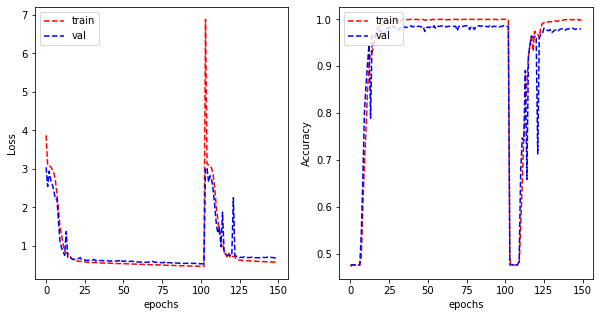

In [83]:
history = VGG_model_with_regularization_with_dropout_02.fit_generator(train_shape, validation_data = validation_shape, epochs=150, verbose=0, class_weight=class_weight_dict_shape)
  
plot_learning_curve(history.history['loss'], history.history['val_loss'], 
                    history.history['categorical_accuracy'], history.history['val_categorical_accuracy'], 
                    metric_name = 'Accuracy')

**Observations:**
- Both `dropout_rate` of 0.2 and 0.5 work very well with this model. The accuracy remains high while overfit is solved. 
- We decided that `dropout_rate` of 0.5 will be saved to be evaluate on the test set as this is the better model in term of overfitting.


In [84]:
VGG_model_with_regularization_with_dropout_05.save("shape_VGG_tuneL2_DropOut_model_05")
!cp -R ./shape_VGG_tuneL2_DropOut_model_05 /content/gdrive/'My Drive'/COSC2673_2110/

INFO:tensorflow:Assets written to: shape_VGG_tuneL2_DropOut_model_05/assets




#### **2.2.2.2 Type Classification**

##### 2.2.2.2.1 VGG Base

In [85]:
VGG_model_sign = create_VGG_Model(numbers_of_sign)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 28, 28, 28)        784       
                                                                 
 conv2d_25 (Conv2D)          (None, 28, 28, 28)        7084      
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 14, 14, 28)       0         
 g2D)                                                            
                                                                 
 conv2d_26 (Conv2D)          (None, 14, 14, 64)        16192     
                                                                 
 conv2d_27 (Conv2D)          (None, 14, 14, 64)        36928     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 7, 7, 64)         0         
 g2D)                                                 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  if sys.path[0] == '':


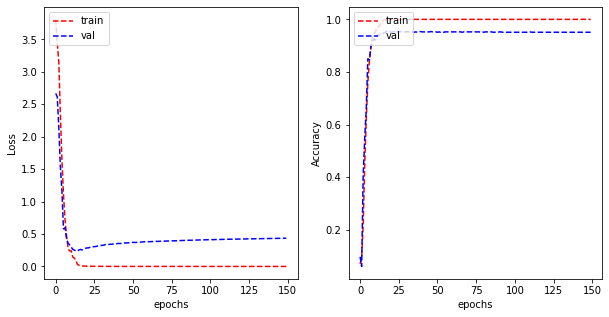

In [86]:
VGG_model_sign.compile(
              # Use sgd over adam as our dataset is not very large so we care more about generalized
              # adam would be better in case we need the data to be able to converge faster
              optimizer = 'sgd',
              # Use categorical_crossentropy instead of sparse as we use one hot label encoder
              loss = "categorical_crossentropy",     
              metrics = ['categorical_accuracy'])
  
# Early stopping is included to prevent long training time
# Training will be interupt if there is no further improvement in validation set
# restore_best_weights arguement is used to return the model to the best model
history = VGG_model_sign.fit_generator(train_type, validation_data = validation_type, epochs=150, class_weight=class_weight_dict_sign, verbose=0)
  
plot_learning_curve(history.history['loss'], history.history['val_loss'], 
                    history.history['categorical_accuracy'], history.history['val_categorical_accuracy'], 
                    metric_name = 'Accuracy')

In [87]:
VGG_model_sign.save("sign_VGG_base_model")
!cp -R ./sign_VGG_base_model /content/gdrive/'My Drive'/COSC2673_2110/

INFO:tensorflow:Assets written to: sign_VGG_base_model/assets


#####2.2.2.2.2 LeNet Base

In [88]:
LeNet_model_sign = create_LeNet_model(numbers_of_sign)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  if sys.path[0] == '':


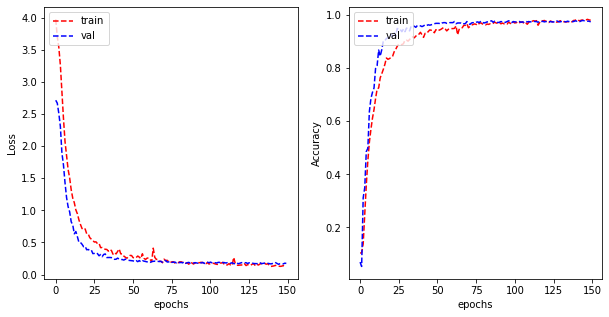

In [89]:
LeNet_model_sign.compile(
              # Use sgd over adam as our dataset is not very large so we care more about generalized
              # adam would be better in case we need the data to be able to converge faster
              optimizer = 'sgd',
              # Use categorical_crossentropy instead of sparse as we use one hot label encoder
              loss = "categorical_crossentropy",     
              metrics = ['categorical_accuracy'])
  
# Early stopping is included to prevent long training time
# Training will be interupt if there is no further improvement in validation set
# restore_best_weights arguement is used to return the model to the best model
history = LeNet_model_sign.fit_generator(train_type, validation_data = validation_type, epochs=150, class_weight=class_weight_dict_sign, verbose=0)
  
plot_learning_curve(history.history['loss'], history.history['val_loss'], 
                    history.history['categorical_accuracy'], history.history['val_categorical_accuracy'], 
                    metric_name = 'Accuracy')

In [90]:
LeNet_model_sign.save("sign_LeNet_base_model")
!cp -R ./sign_LeNet_base_model /content/gdrive/'My Drive'/COSC2673_2110/

INFO:tensorflow:Assets written to: sign_LeNet_base_model/assets


##### **2.2.2.2.3 L2 Regularization (tuning regularization lambda)**

In [91]:

def parameters_sign(reg_lambda, output):
    VGG_model_with_regularization = tf.keras.Sequential([
    # Block 1
    tf.keras.layers.Conv2D(28, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer = tf.keras.regularizers.L2(reg_lambda), input_shape=input_dimension),
    tf.keras.layers.Conv2D(28, (3, 3), activation='relu', padding='same',
                           kernel_regularizer= tf.keras.regularizers.L2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    # Block 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same',
                           kernel_regularizer=tf.keras.regularizers.L2(reg_lambda)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same',
                                  kernel_regularizer=tf.keras.regularizers.L2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    # Block 3
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same',
                           kernel_regularizer=tf.keras.regularizers.L2(reg_lambda)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.L2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(reg_lambda)),
    tf.keras.layers.Dense(output, activation = "softmax"),
    ])

    VGG_model_with_regularization.compile(
              # Use sgd over adam as our dataset is not very large so we care more about generalized
              # adam would be better in case we need the data to be able to converge faster
              optimizer = 'sgd',
              # Use categorical_crossentropy instead of sparse as we use one hot label encoder
              loss = "categorical_crossentropy",     
              metrics = ['categorical_accuracy'])
  
    return VGG_model_with_regularization
    
def build_model_VGG_l2_reg_sign(hp):
    reg_lambda = hp.Choice('reg_lambda', [0.001, 0.01, 0.1])
    model = parameters_sign(reg_lambda, numbers_of_sign)
    return model

build_model_VGG_l2_reg_sign(kt.HyperParameters())

In [92]:
tuner_reg_l2_sign = kt.RandomSearch(
    build_model_VGG_l2_reg_sign,
    objective='val_loss',
    max_trials=3,
    overwrite = True)
tuner_reg_l2_sign.search_space_summary()

Search space summary
Default search space size: 1
reg_lambda (Choice)
{'default': 0.001, 'conditions': [], 'values': [0.001, 0.01, 0.1], 'ordered': True}


In [93]:
tuner_reg_l2_sign.search(train_type, epochs=150, verbose = 0, validation_data=validation_type, class_weight=class_weight_dict_sign)

INFO:tensorflow:Oracle triggered exit


In [94]:
tuner_reg_l2_sign.results_summary()

Results summary
Results in ./untitled_project
Showing 10 best trials
Trial summary
Hyperparameters:
reg_lambda: 0.01
Score: 0.5467212200164795
Trial summary
Hyperparameters:
reg_lambda: 0.001
Score: 0.6578598618507385
Trial summary
Hyperparameters:
reg_lambda: 0.1
Score: 1.4491726160049438


In [95]:
# get best model and best hyper parameter
best_model = tuner_reg_l2_sign.get_best_models()[0]
best_hp = tuner_reg_l2_sign.get_best_hyperparameters()[0]
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 28)        784       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 28)        7084      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 28)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 64)        16192     
                                                                 
 conv2d_3 (Conv2D)           (None, 14, 14, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                    

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


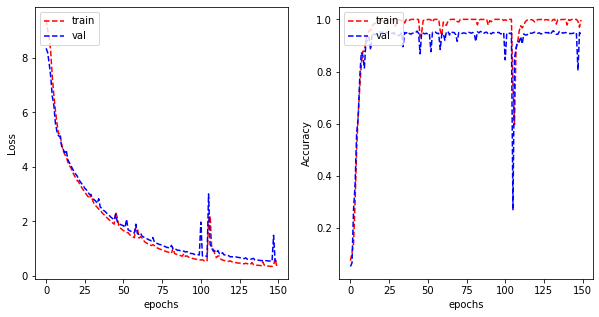

In [96]:
model_VGG_best_regularization_sign = tuner_reg_l2_sign.hypermodel.build(best_hp)
history = model_VGG_best_regularization_sign.fit_generator(train_type, validation_data = validation_type, epochs=150, verbose=0, class_weight=class_weight_dict_sign)
  
plot_learning_curve(history.history['loss'], history.history['val_loss'], 
                    history.history['categorical_accuracy'], history.history['val_categorical_accuracy'], 
                    metric_name = 'Accuracy')

**Observations**:
- Although regularization has been applied, it seems like the data is still quite overfit. For this reason `dropout` is applied in the next section.

##### **2.2.2.2.4 Dropout Regularization (tuning dropout rate)**

In [97]:
reg_lambda = 0.01
dropout_rate = 0.5

VGG_model_with_regularization_with_dropout_05 = tf.keras.Sequential([
  # Block 1
  tf.keras.layers.Conv2D(28, (3, 3), activation='relu', padding='same', 
                          kernel_regularizer = tf.keras.regularizers.l2(reg_lambda), input_shape=input_dimension),
  tf.keras.layers.Conv2D(28, (3, 3), activation='relu', padding='same',
                          kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
  tf.keras.layers.MaxPooling2D((2, 2)),
  
  # Block 2
  tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same',
                          kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
  tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same',
                                kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
  tf.keras.layers.MaxPooling2D((2, 2)),
  
  # Block 3
  tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same',
                          kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
  tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', 
                          kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
  tf.keras.layers.MaxPooling2D((2, 2)),
  
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
  tf.keras.layers.Dropout(rate = dropout_rate),
  tf.keras.layers.Dense(numbers_of_sign, activation = "softmax"),
  ])

VGG_model_with_regularization_with_dropout_05.compile(
          # Use sgd over adam as our dataset is not very large so we care more about generalized
          # adam would be better in case we need the data to be able to converge faster
          optimizer = 'sgd',
          # Use categorical_crossentropy instead of sparse as we use one hot label encoder
          loss = "categorical_crossentropy",     
          metrics = ['categorical_accuracy'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """Entry point for launching an IPython kernel.


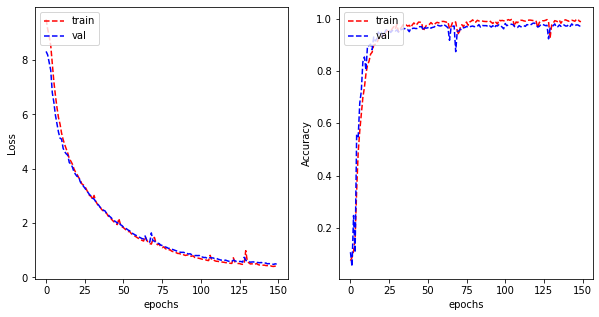

In [98]:
history = VGG_model_with_regularization_with_dropout_05.fit_generator(train_type, validation_data = validation_type, epochs=150, verbose=0, class_weight=class_weight_dict_sign)
  
plot_learning_curve(history.history['loss'], history.history['val_loss'], 
                    history.history['categorical_accuracy'], history.history['val_categorical_accuracy'], 
                    metric_name = 'Accuracy')

In [99]:
reg_lambda = 0.001
dropout_rate = 0.2

VGG_model_with_regularization_with_dropout_02 = tf.keras.Sequential([
  # Block 1
  tf.keras.layers.Conv2D(28, (3, 3), activation='relu', padding='same', 
                          kernel_regularizer = tf.keras.regularizers.l2(reg_lambda), input_shape=input_dimension),
  tf.keras.layers.Conv2D(28, (3, 3), activation='relu', padding='same',
                          kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
  tf.keras.layers.MaxPooling2D((2, 2)),
  
  # Block 2
  tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same',
                          kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
  tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same',
                                kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
  tf.keras.layers.MaxPooling2D((2, 2)),
  
  # Block 3
  tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same',
                          kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
  tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', 
                          kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
  tf.keras.layers.MaxPooling2D((2, 2)),
  
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
  tf.keras.layers.Dropout(rate = dropout_rate),
  tf.keras.layers.Dense(numbers_of_sign, activation = "softmax"),
  ])

VGG_model_with_regularization_with_dropout_02.compile(
          # Use sgd over adam as our dataset is not very large so we care more about generalized
          # adam would be better in case we need the data to be able to converge faster
          optimizer = 'sgd',
          # Use categorical_crossentropy instead of sparse as we use one hot label encoder
          loss = "categorical_crossentropy",     
          metrics = ['categorical_accuracy'])
  
  



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """Entry point for launching an IPython kernel.


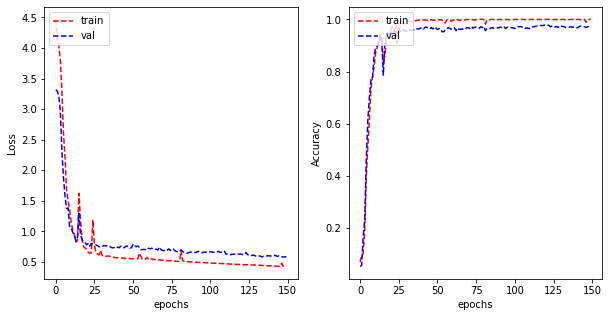

In [100]:
history = VGG_model_with_regularization_with_dropout_02.fit_generator(train_type, validation_data = validation_type, epochs=150, verbose=0, class_weight=class_weight_dict_sign)
  
plot_learning_curve(history.history['loss'], history.history['val_loss'], 
                    history.history['categorical_accuracy'], history.history['val_categorical_accuracy'], 
                    metric_name = 'Accuracy')

In [101]:
VGG_model_with_regularization_with_dropout_05.save("sign_VGG_tuneL2_Dropout_model_05")
!cp -R ./sign_VGG_tuneL2_Dropout_model_05 /content/gdrive/'My Drive'/COSC2673_2110/

INFO:tensorflow:Assets written to: sign_VGG_tuneL2_Dropout_model_05/assets


## **2.3. Test Set Result**

In this section, all the model that was saved will be evaluated on the testing set.

In [102]:
# Loading shape model
shape_MLP_base = keras.models.load_model('/content/gdrive/MyDrive/COSC2673_2110/shape_based_MLP_model')
shape_MLP_tuned = keras.models.load_model('/content/gdrive/MyDrive/COSC2673_2110/shape_fine_tuned_MLP_model')
shape_MLP_tuned_augmented = keras.models.load_model('/content/gdrive/MyDrive/COSC2673_2110/shape_model_mlp_augmented')
shape_LeNet_base = keras.models.load_model('/content/gdrive/MyDrive/COSC2673_2110/shape_LeNet_base_model')
shape_VGG_base = keras.models.load_model('/content/gdrive/MyDrive/COSC2673_2110/shape_VGG_base_model')
shape_VGG_tuneL2_DropOut05 = keras.models.load_model('/content/gdrive/MyDrive/COSC2673_2110/shape_VGG_tuneL2_DropOut_model_05')

# Loading sign model
sign_MLP_base = keras.models.load_model('/content/gdrive/MyDrive/COSC2673_2110/sign_base_model_mlp')
sign_MLP_tuned = keras.models.load_model('/content/gdrive/MyDrive/COSC2673_2110/sign_fine_tuned_MLP_model')
sign_MLP_tuned_augmented = keras.models.load_model('/content/gdrive/MyDrive/COSC2673_2110/sign_model_mpl_augmented')
sign_LeNet_base = keras.models.load_model('/content/gdrive/MyDrive/COSC2673_2110/sign_LeNet_base_model')
sign_VGG_base = keras.models.load_model('/content/gdrive/MyDrive/COSC2673_2110/sign_VGG_base_model')
sign_VGG_tuneL2_DropOut05 = keras.models.load_model('/content/gdrive/MyDrive/COSC2673_2110/sign_VGG_tuneL2_Dropout_model_05')

In [103]:
target_names_shape = ["diamond", "hex", "round", "square", "triangle"]
target_names_sign = ["rightofway", "stop", "bicycle", "limitedtraffic", "noentry", "noparking", "roundabout", "speed", "trafficdirective", "traveldirection", "continue", "crossing", "laneend", "parking", "giveway", "warning"]

In [104]:
# This list of result will save the result for all models 
list_of_shape_result = []
list_of_sign_result = []

In [105]:
def test_evaluation(model, model_name, y_true, target_names, dataset):
    prediction = model.predict(y_true, workers = 1)
    y_pred = np.argmax(prediction, axis=1)
    cm = confusion_matrix(y_true.classes, y_pred)
    fig, ax = plt.subplots(figsize=(6, 6))
    sns.heatmap(cm, annot=True,  fmt=".0f", ax = ax, xticklabels=target_names, yticklabels= target_names)
    ax.set(xlabel='Predicted label', ylabel='True label')
    plt.show()
    print("\n" + classification_report(y_true.classes, y_pred, target_names=target_names))
    result = classification_report(y_true.classes, y_pred, target_names=target_names, output_dict = True)
    if target_names == target_names_shape:
      list_of_shape_result.append([model_name, result, dataset])
    else:
      list_of_sign_result.append([model_name, result, dataset])

### **2.3.1. Test Set 1**

In [106]:
test_set_1_shape = generating_data_from_dataframe(test_data, "sign_shape", test = True)
test_set_1_sign = generating_data_from_dataframe(test_data, "sign_type", test = True)

Found 750 validated image filenames belonging to 5 classes.
Found 750 validated image filenames belonging to 16 classes.


#### 2.3.1.1 Shape Classification

**Observations Summary**:
- As expected most CNN model performs better than MLP models. 
- Due to class imbalance Hex classification often getting a lower F1 score when comparing to other classes. Applying augmented data on to MLP model, however, improves the prediction of this class when comparing to the Base MLP model.
- By implementing `regularization` and `dropout` VGG model not only out-perform the base VGG model but also out-perform LeNet model in term of overall accuracy. 


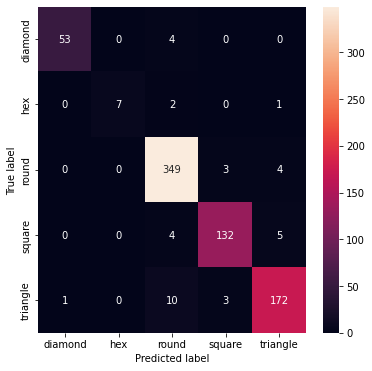


              precision    recall  f1-score   support

     diamond       0.98      0.93      0.95        57
         hex       1.00      0.70      0.82        10
       round       0.95      0.98      0.96       356
      square       0.96      0.94      0.95       141
    triangle       0.95      0.92      0.93       186

    accuracy                           0.95       750
   macro avg       0.97      0.89      0.92       750
weighted avg       0.95      0.95      0.95       750



In [107]:
test_evaluation(shape_MLP_base, "Shape MLP Base", test_set_1_shape, target_names_shape, "Dataset 1")

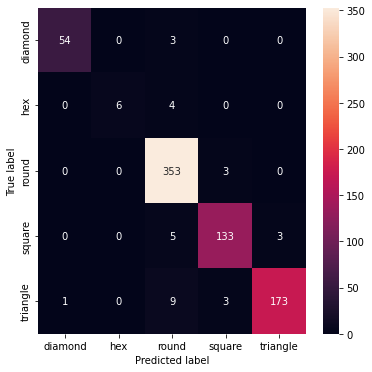


              precision    recall  f1-score   support

     diamond       0.98      0.95      0.96        57
         hex       1.00      0.60      0.75        10
       round       0.94      0.99      0.97       356
      square       0.96      0.94      0.95       141
    triangle       0.98      0.93      0.96       186

    accuracy                           0.96       750
   macro avg       0.97      0.88      0.92       750
weighted avg       0.96      0.96      0.96       750



In [108]:
test_evaluation(shape_MLP_tuned, "Shape MLP Tuned", test_set_1_shape, target_names_shape, "Dataset 1")

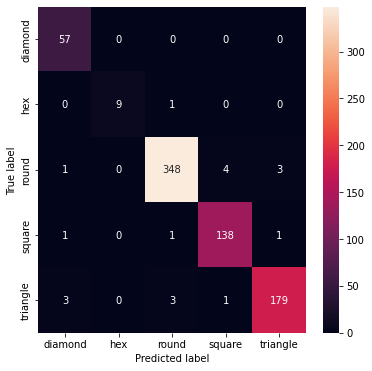


              precision    recall  f1-score   support

     diamond       0.92      1.00      0.96        57
         hex       1.00      0.90      0.95        10
       round       0.99      0.98      0.98       356
      square       0.97      0.98      0.97       141
    triangle       0.98      0.96      0.97       186

    accuracy                           0.97       750
   macro avg       0.97      0.96      0.97       750
weighted avg       0.98      0.97      0.97       750



In [109]:
test_evaluation(shape_MLP_tuned_augmented, "Shape MLP Tuned with Data Augmented", test_set_1_shape, target_names_shape, "Dataset 1")


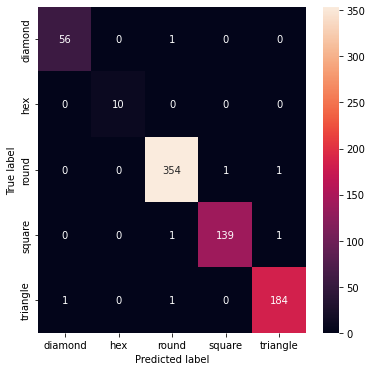


              precision    recall  f1-score   support

     diamond       0.98      0.98      0.98        57
         hex       1.00      1.00      1.00        10
       round       0.99      0.99      0.99       356
      square       0.99      0.99      0.99       141
    triangle       0.99      0.99      0.99       186

    accuracy                           0.99       750
   macro avg       0.99      0.99      0.99       750
weighted avg       0.99      0.99      0.99       750



In [110]:
test_evaluation(shape_LeNet_base, "Shape LeNet Base", test_set_1_shape, target_names_shape, "Dataset 1")

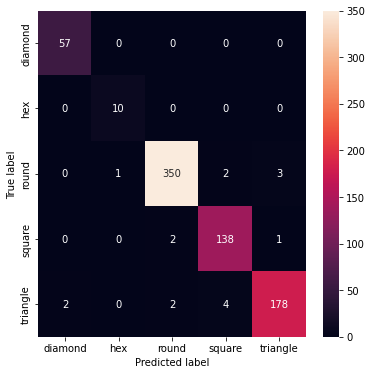


              precision    recall  f1-score   support

     diamond       0.97      1.00      0.98        57
         hex       0.91      1.00      0.95        10
       round       0.99      0.98      0.99       356
      square       0.96      0.98      0.97       141
    triangle       0.98      0.96      0.97       186

    accuracy                           0.98       750
   macro avg       0.96      0.98      0.97       750
weighted avg       0.98      0.98      0.98       750



In [111]:
test_evaluation(shape_VGG_base, "Shape VGG Base", test_set_1_shape, target_names_shape, "Dataset 1")

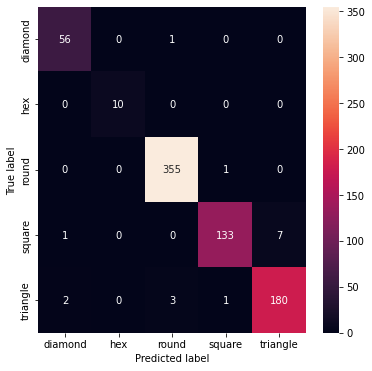


              precision    recall  f1-score   support

     diamond       0.95      0.98      0.97        57
         hex       1.00      1.00      1.00        10
       round       0.99      1.00      0.99       356
      square       0.99      0.94      0.96       141
    triangle       0.96      0.97      0.97       186

    accuracy                           0.98       750
   macro avg       0.98      0.98      0.98       750
weighted avg       0.98      0.98      0.98       750



In [112]:
test_evaluation(shape_VGG_tuneL2_DropOut05, "Shape VGG tuned L2 and DropOut", test_set_1_shape, target_names_shape, "Dataset 1")

#### 2.3.1.2 Sign Classification

**Observations Summary:**
- Similar to shape classificaiton, sign-type classes that have less data entries also getting lower prediction score (Example: crossing).
- LeNet Base Model and the Tuned VGG Model continues to be the best performer in term of accuracy.

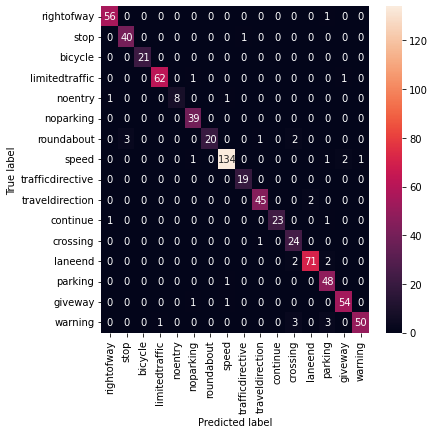


                  precision    recall  f1-score   support

      rightofway       0.97      0.98      0.97        57
            stop       0.93      0.98      0.95        41
         bicycle       1.00      1.00      1.00        21
  limitedtraffic       0.98      0.97      0.98        64
         noentry       1.00      0.80      0.89        10
       noparking       0.93      1.00      0.96        39
      roundabout       1.00      0.77      0.87        26
           speed       0.98      0.96      0.97       139
trafficdirective       0.95      1.00      0.97        19
 traveldirection       0.96      0.96      0.96        47
        continue       1.00      0.92      0.96        25
        crossing       0.77      0.96      0.86        25
         laneend       0.97      0.95      0.96        75
         parking       0.86      0.98      0.91        49
         giveway       0.95      0.96      0.96        56
         warning       0.98      0.88      0.93        57

        acc

In [113]:
test_evaluation(sign_MLP_base, "Sign MLP Base", test_set_1_sign, target_names_sign, "Dataset 1")

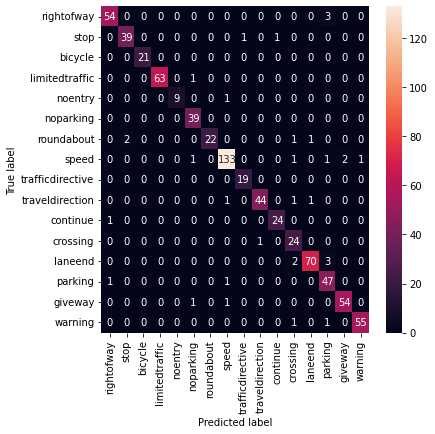


                  precision    recall  f1-score   support

      rightofway       0.96      0.95      0.96        57
            stop       0.95      0.95      0.95        41
         bicycle       1.00      1.00      1.00        21
  limitedtraffic       1.00      0.98      0.99        64
         noentry       1.00      0.90      0.95        10
       noparking       0.93      1.00      0.96        39
      roundabout       1.00      0.85      0.92        26
           speed       0.97      0.96      0.96       139
trafficdirective       0.95      1.00      0.97        19
 traveldirection       0.98      0.94      0.96        47
        continue       0.96      0.96      0.96        25
        crossing       0.80      0.96      0.87        25
         laneend       0.97      0.93      0.95        75
         parking       0.85      0.96      0.90        49
         giveway       0.96      0.96      0.96        56
         warning       0.98      0.96      0.97        57

        acc

In [114]:
test_evaluation(sign_MLP_tuned, "Sign MLP Tuned", test_set_1_sign, target_names_sign, "Dataset 1")

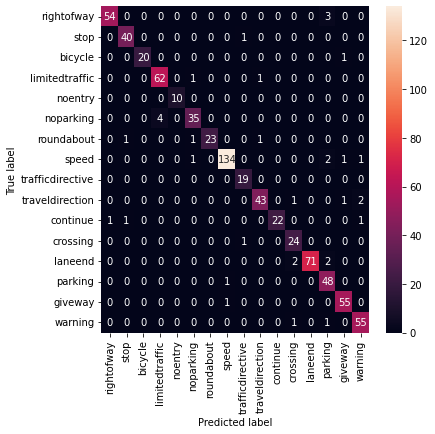


                  precision    recall  f1-score   support

      rightofway       0.98      0.95      0.96        57
            stop       0.95      0.98      0.96        41
         bicycle       1.00      0.95      0.98        21
  limitedtraffic       0.94      0.97      0.95        64
         noentry       1.00      1.00      1.00        10
       noparking       0.92      0.90      0.91        39
      roundabout       1.00      0.88      0.94        26
           speed       0.99      0.96      0.97       139
trafficdirective       0.90      1.00      0.95        19
 traveldirection       0.96      0.91      0.93        47
        continue       1.00      0.88      0.94        25
        crossing       0.86      0.96      0.91        25
         laneend       1.00      0.95      0.97        75
         parking       0.86      0.98      0.91        49
         giveway       0.95      0.98      0.96        56
         warning       0.93      0.96      0.95        57

        acc

In [115]:
test_evaluation(sign_MLP_tuned_augmented, "Sign MLP Tuned with Data Augmented", test_set_1_sign, target_names_sign, "Dataset 1")

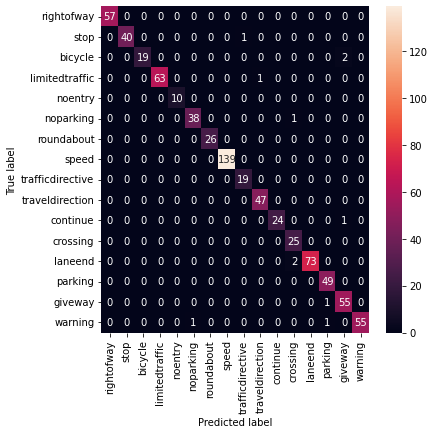


                  precision    recall  f1-score   support

      rightofway       1.00      1.00      1.00        57
            stop       1.00      0.98      0.99        41
         bicycle       1.00      0.90      0.95        21
  limitedtraffic       1.00      0.98      0.99        64
         noentry       1.00      1.00      1.00        10
       noparking       0.97      0.97      0.97        39
      roundabout       1.00      1.00      1.00        26
           speed       1.00      1.00      1.00       139
trafficdirective       0.95      1.00      0.97        19
 traveldirection       0.98      1.00      0.99        47
        continue       1.00      0.96      0.98        25
        crossing       0.89      1.00      0.94        25
         laneend       1.00      0.97      0.99        75
         parking       0.96      1.00      0.98        49
         giveway       0.95      0.98      0.96        56
         warning       1.00      0.96      0.98        57

        acc

In [116]:
test_evaluation(sign_LeNet_base, "Sign LeNet Base", test_set_1_sign, target_names_sign, "Dataset 1")

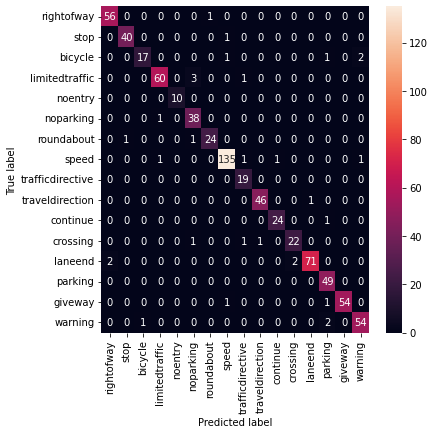


                  precision    recall  f1-score   support

      rightofway       0.97      0.98      0.97        57
            stop       0.98      0.98      0.98        41
         bicycle       0.94      0.81      0.87        21
  limitedtraffic       0.97      0.94      0.95        64
         noentry       1.00      1.00      1.00        10
       noparking       0.88      0.97      0.93        39
      roundabout       0.96      0.92      0.94        26
           speed       0.98      0.97      0.97       139
trafficdirective       0.86      1.00      0.93        19
 traveldirection       0.98      0.98      0.98        47
        continue       0.96      0.96      0.96        25
        crossing       0.92      0.88      0.90        25
         laneend       0.99      0.95      0.97        75
         parking       0.91      1.00      0.95        49
         giveway       1.00      0.96      0.98        56
         warning       0.95      0.95      0.95        57

        acc

In [117]:
test_evaluation(sign_VGG_base, "Sign VGG Base", test_set_1_sign, target_names_sign, "Dataset 1")

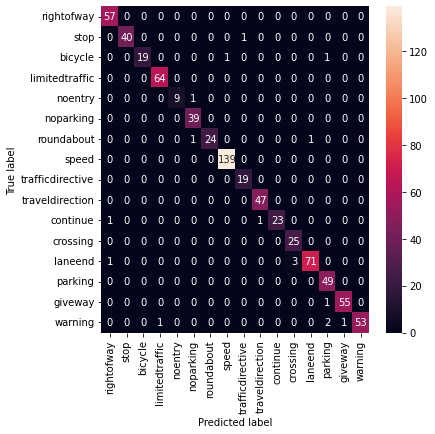


                  precision    recall  f1-score   support

      rightofway       0.97      1.00      0.98        57
            stop       1.00      0.98      0.99        41
         bicycle       1.00      0.90      0.95        21
  limitedtraffic       0.98      1.00      0.99        64
         noentry       1.00      0.90      0.95        10
       noparking       0.95      1.00      0.97        39
      roundabout       1.00      0.92      0.96        26
           speed       0.99      1.00      1.00       139
trafficdirective       0.95      1.00      0.97        19
 traveldirection       0.98      1.00      0.99        47
        continue       1.00      0.92      0.96        25
        crossing       0.89      1.00      0.94        25
         laneend       0.99      0.95      0.97        75
         parking       0.92      1.00      0.96        49
         giveway       0.98      0.98      0.98        56
         warning       1.00      0.93      0.96        57

        acc

In [118]:
test_evaluation(sign_VGG_tuneL2_DropOut05, "Sign VGG Tune L2 and DropOut", test_set_1_sign, target_names_sign, "Dataset 1")

### **2.3.2. Test Set 2**

In this section, we will test our model on the independent Australian test set, it is expected that the performance on this test set will be lower than the previous set, especially in sign-type classificaiton. 

This is due to the differences between the Australian sign-type and Belgium sign-type.

In [119]:
data_independent = file_path_into_dataframe('./independent_data/*/*/*.png')
data_independent.head()  

,image_path,sign_shape,sign_type
0,./independent_data/diamond/laneend/1232.png,diamond,laneend
1,./independent_data/diamond/laneend/02333.png,diamond,laneend
2,./independent_data/diamond/laneend/1111.png,diamond,laneend
3,./independent_data/diamond/rightofway/008.png,diamond,rightofway
4,./independent_data/diamond/rightofway/018.png,diamond,rightofway


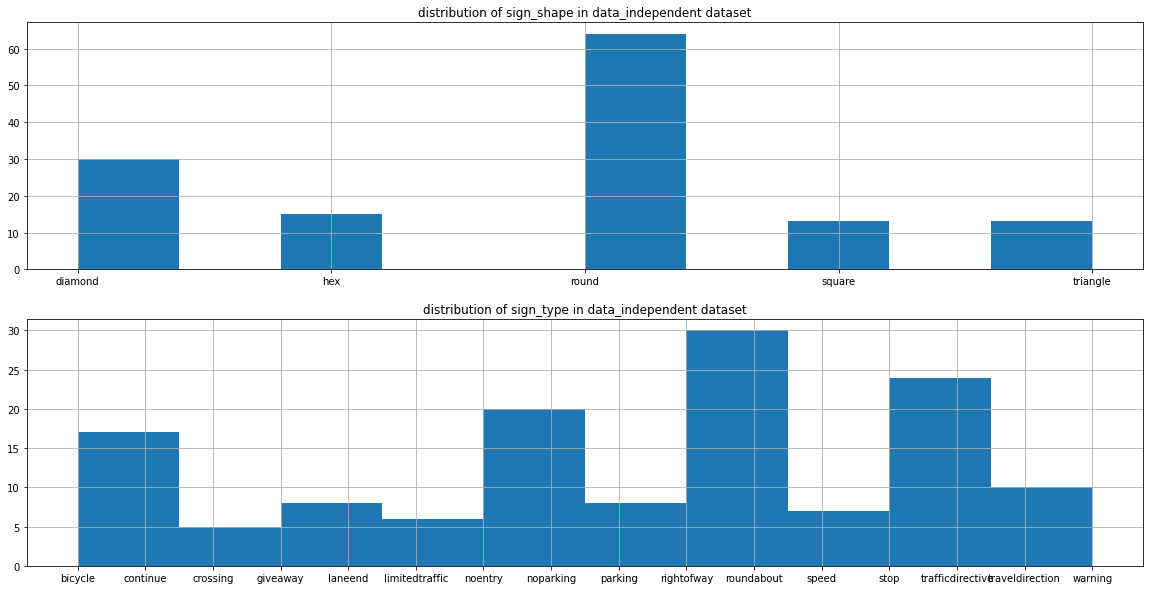

In [120]:
plot_distribution(data_independent, "data_independent")

In [121]:
label_encoder(data_independent)
data_independent.head()

,image_path,sign_shape,sign_type
0,./independent_data/diamond/laneend/1232.png,0,4
1,./independent_data/diamond/laneend/02333.png,0,4
2,./independent_data/diamond/laneend/1111.png,0,4
3,./independent_data/diamond/rightofway/008.png,0,9
4,./independent_data/diamond/rightofway/018.png,0,9


In [122]:
test_set_2_shape = generating_data_from_dataframe(data_independent, "sign_shape", to_grayscale, test = True)
test_set_2_sign = generating_data_from_dataframe(data_independent, "sign_type", to_grayscale, test = True)

Found 135 validated image filenames belonging to 5 classes.
Found 135 validated image filenames belonging to 16 classes.


#### 2.3.2.1 Shape Classification

**Obvervations Summary:**
- As expected, the performance of our model on this test set is much worse than the performance on the previous test set, especially in the case of base model MLP without the agumented data (only getting 0 F1 score for `hex` class).
- When augmented data is included, the model predict much better for `hex` class and the overall accuracy is also increased from +-0.3 to +-0.5.
- CNN models once again showing it can predict better than MLP model (best MLP model getting accuracy of +-0.5 while the lowest CNN geting +-0.6) 

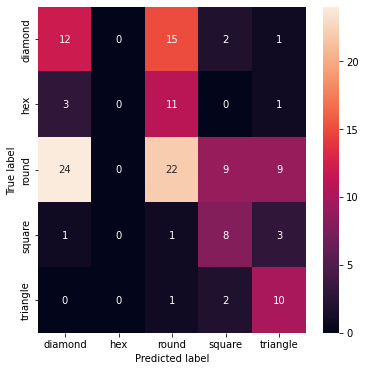


              precision    recall  f1-score   support

     diamond       0.30      0.40      0.34        30
         hex       0.00      0.00      0.00        15
       round       0.44      0.34      0.39        64
      square       0.38      0.62      0.47        13
    triangle       0.42      0.77      0.54        13

    accuracy                           0.39       135
   macro avg       0.31      0.43      0.35       135
weighted avg       0.35      0.39      0.36       135



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

In [123]:
test_evaluation(shape_MLP_base, "Shape MLP Base", test_set_2_shape, target_names_shape, "Dataset 2")

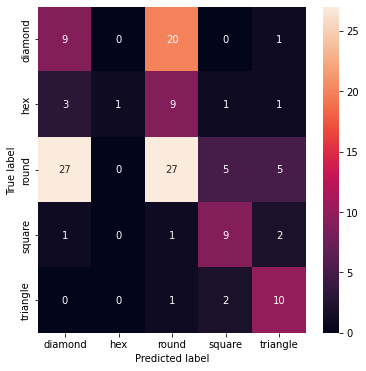


              precision    recall  f1-score   support

     diamond       0.23      0.30      0.26        30
         hex       1.00      0.07      0.12        15
       round       0.47      0.42      0.44        64
      square       0.53      0.69      0.60        13
    triangle       0.53      0.77      0.62        13

    accuracy                           0.41       135
   macro avg       0.55      0.45      0.41       135
weighted avg       0.48      0.41      0.40       135



In [124]:
test_evaluation(shape_MLP_tuned, "Shape MLP Tuned", test_set_2_shape, target_names_shape, "Dataset 2")

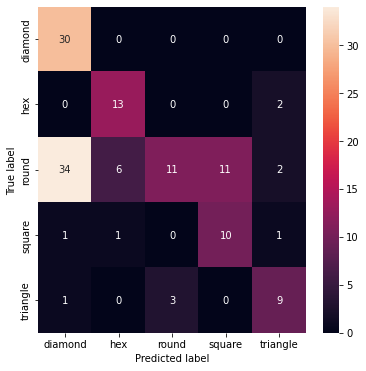


              precision    recall  f1-score   support

     diamond       0.45      1.00      0.62        30
         hex       0.65      0.87      0.74        15
       round       0.79      0.17      0.28        64
      square       0.48      0.77      0.59        13
    triangle       0.64      0.69      0.67        13

    accuracy                           0.54       135
   macro avg       0.60      0.70      0.58       135
weighted avg       0.65      0.54      0.48       135



In [125]:
test_evaluation(shape_MLP_tuned_augmented, "Shape MLP Tuned with Data Augmented", test_set_2_shape, target_names_shape, "Dataset 2")

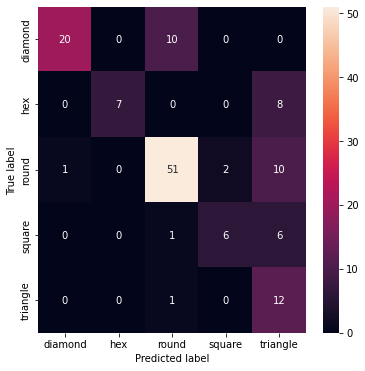


              precision    recall  f1-score   support

     diamond       0.95      0.67      0.78        30
         hex       1.00      0.47      0.64        15
       round       0.81      0.80      0.80        64
      square       0.75      0.46      0.57        13
    triangle       0.33      0.92      0.49        13

    accuracy                           0.71       135
   macro avg       0.77      0.66      0.66       135
weighted avg       0.81      0.71      0.73       135



In [126]:
test_evaluation(shape_LeNet_base, "Shape LeNet Base", test_set_2_shape, target_names_shape, "Dataset 2")

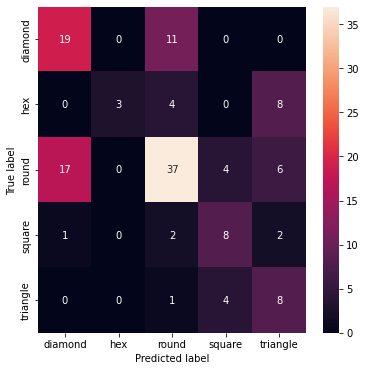


              precision    recall  f1-score   support

     diamond       0.51      0.63      0.57        30
         hex       1.00      0.20      0.33        15
       round       0.67      0.58      0.62        64
      square       0.50      0.62      0.55        13
    triangle       0.33      0.62      0.43        13

    accuracy                           0.56       135
   macro avg       0.60      0.53      0.50       135
weighted avg       0.62      0.56      0.55       135



In [127]:
test_evaluation(shape_VGG_base, "Shape VGG Base", test_set_2_shape, target_names_shape, "Dataset 2")

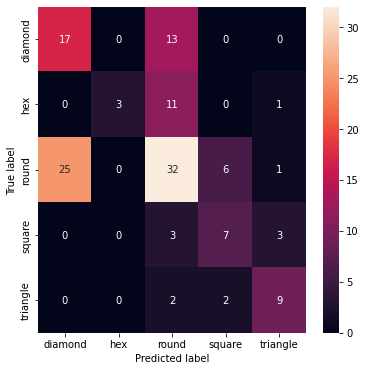


              precision    recall  f1-score   support

     diamond       0.40      0.57      0.47        30
         hex       1.00      0.20      0.33        15
       round       0.52      0.50      0.51        64
      square       0.47      0.54      0.50        13
    triangle       0.64      0.69      0.67        13

    accuracy                           0.50       135
   macro avg       0.61      0.50      0.50       135
weighted avg       0.56      0.50      0.50       135



In [128]:
test_evaluation(shape_VGG_tuneL2_DropOut05, "Shape VGG tuned L2 and DropOut", test_set_2_shape, target_names_shape, "Dataset 2")

#### 2.3.1.2 Sign Classification

**Observations Summary:**
- Sign-type classification shows much worse result when comparing to sign-shape classification on this dataset with the best model only getting +-40% accuracy.
- This suggests that if the models were to be used in another counntry it would need to be re-trained using the sign-type of that specific country.

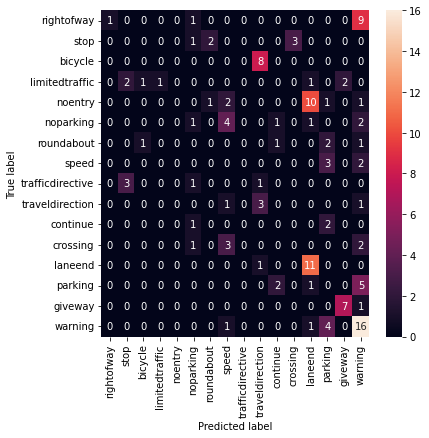


                  precision    recall  f1-score   support

      rightofway       1.00      0.09      0.17        11
            stop       0.00      0.00      0.00         6
         bicycle       0.00      0.00      0.00         8
  limitedtraffic       1.00      0.14      0.25         7
         noentry       0.00      0.00      0.00        15
       noparking       0.17      0.11      0.13         9
      roundabout       0.00      0.00      0.00         5
           speed       0.00      0.00      0.00         5
trafficdirective       0.00      0.00      0.00         5
 traveldirection       0.23      0.60      0.33         5
        continue       0.00      0.00      0.00         3
        crossing       0.00      0.00      0.00         6
         laneend       0.44      0.92      0.59        12
         parking       0.00      0.00      0.00         8
         giveway       0.78      0.88      0.82         8
         warning       0.40      0.73      0.52        22

        acc

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

In [129]:
test_evaluation(sign_MLP_base, "Sign MLP Base", test_set_2_sign, target_names_sign, "Dataset 2")

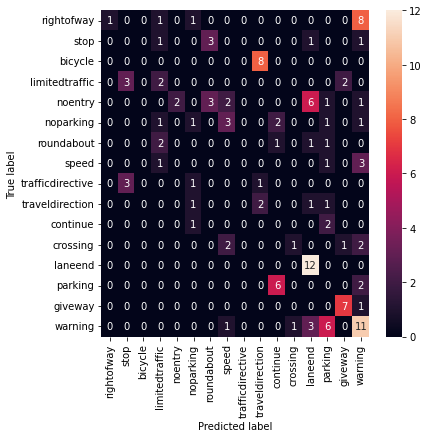


                  precision    recall  f1-score   support

      rightofway       1.00      0.09      0.17        11
            stop       0.00      0.00      0.00         6
         bicycle       0.00      0.00      0.00         8
  limitedtraffic       0.25      0.29      0.27         7
         noentry       1.00      0.13      0.24        15
       noparking       0.20      0.11      0.14         9
      roundabout       0.00      0.00      0.00         5
           speed       0.00      0.00      0.00         5
trafficdirective       0.00      0.00      0.00         5
 traveldirection       0.18      0.40      0.25         5
        continue       0.00      0.00      0.00         3
        crossing       0.50      0.17      0.25         6
         laneend       0.50      1.00      0.67        12
         parking       0.00      0.00      0.00         8
         giveway       0.70      0.88      0.78         8
         warning       0.37      0.50      0.42        22

        acc

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

In [130]:
test_evaluation(sign_MLP_tuned, "Sign MLP Tuned", test_set_2_sign, target_names_sign, "Dataset 2")


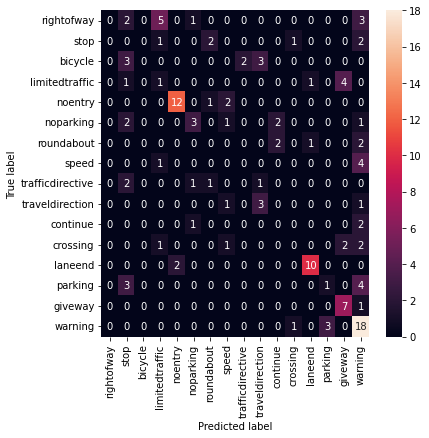


                  precision    recall  f1-score   support

      rightofway       0.00      0.00      0.00        11
            stop       0.00      0.00      0.00         6
         bicycle       0.00      0.00      0.00         8
  limitedtraffic       0.11      0.14      0.12         7
         noentry       0.86      0.80      0.83        15
       noparking       0.50      0.33      0.40         9
      roundabout       0.00      0.00      0.00         5
           speed       0.00      0.00      0.00         5
trafficdirective       0.00      0.00      0.00         5
 traveldirection       0.43      0.60      0.50         5
        continue       0.00      0.00      0.00         3
        crossing       0.00      0.00      0.00         6
         laneend       0.83      0.83      0.83        12
         parking       0.25      0.12      0.17         8
         giveway       0.54      0.88      0.67         8
         warning       0.45      0.82      0.58        22

        acc

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

In [131]:
test_evaluation(sign_MLP_tuned_augmented, "Sign MLP Tuned with Data Augmented", test_set_2_sign, target_names_sign, "Dataset 2")


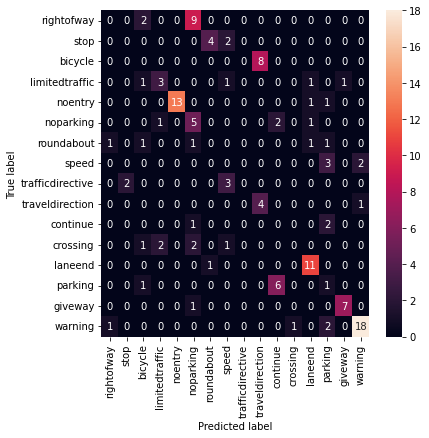


                  precision    recall  f1-score   support

      rightofway       0.00      0.00      0.00        11
            stop       0.00      0.00      0.00         6
         bicycle       0.00      0.00      0.00         8
  limitedtraffic       0.50      0.43      0.46         7
         noentry       1.00      0.87      0.93        15
       noparking       0.26      0.56      0.36         9
      roundabout       0.00      0.00      0.00         5
           speed       0.00      0.00      0.00         5
trafficdirective       0.00      0.00      0.00         5
 traveldirection       0.33      0.80      0.47         5
        continue       0.00      0.00      0.00         3
        crossing       0.00      0.00      0.00         6
         laneend       0.73      0.92      0.81        12
         parking       0.10      0.12      0.11         8
         giveway       0.88      0.88      0.88         8
         warning       0.86      0.82      0.84        22

        acc

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

In [132]:
test_evaluation(sign_LeNet_base, "Sign LeNet Base", test_set_2_sign, target_names_sign, "Dataset 2")


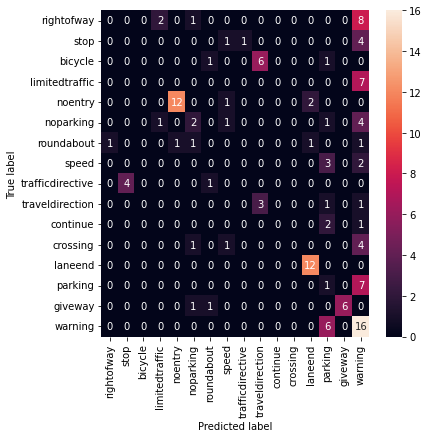


                  precision    recall  f1-score   support

      rightofway       0.00      0.00      0.00        11
            stop       0.00      0.00      0.00         6
         bicycle       0.00      0.00      0.00         8
  limitedtraffic       0.00      0.00      0.00         7
         noentry       0.92      0.80      0.86        15
       noparking       0.33      0.22      0.27         9
      roundabout       0.00      0.00      0.00         5
           speed       0.00      0.00      0.00         5
trafficdirective       0.00      0.00      0.00         5
 traveldirection       0.33      0.60      0.43         5
        continue       0.00      0.00      0.00         3
        crossing       0.00      0.00      0.00         6
         laneend       0.80      1.00      0.89        12
         parking       0.07      0.12      0.09         8
         giveway       1.00      0.75      0.86         8
         warning       0.29      0.73      0.42        22

        acc

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

In [133]:
test_evaluation(sign_VGG_base, "Sign VGG Base", test_set_2_sign, target_names_sign, "Dataset 2")


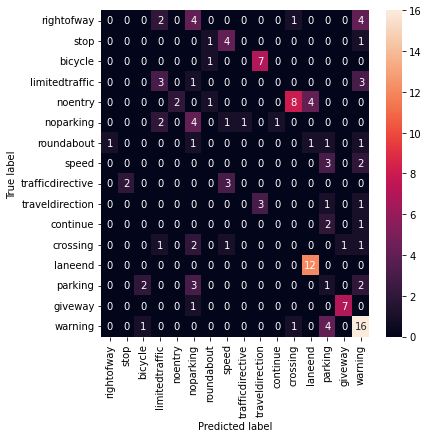


                  precision    recall  f1-score   support

      rightofway       0.00      0.00      0.00        11
            stop       0.00      0.00      0.00         6
         bicycle       0.00      0.00      0.00         8
  limitedtraffic       0.38      0.43      0.40         7
         noentry       1.00      0.13      0.24        15
       noparking       0.25      0.44      0.32         9
      roundabout       0.00      0.00      0.00         5
           speed       0.00      0.00      0.00         5
trafficdirective       0.00      0.00      0.00         5
 traveldirection       0.30      0.60      0.40         5
        continue       0.00      0.00      0.00         3
        crossing       0.00      0.00      0.00         6
         laneend       0.71      1.00      0.83        12
         parking       0.08      0.12      0.10         8
         giveway       0.88      0.88      0.88         8
         warning       0.50      0.73      0.59        22

        acc

In [134]:
test_evaluation(sign_VGG_tuneL2_DropOut05, "Sign VGG Tune L2 and DropOut", test_set_2_sign, target_names_sign, "Dataset 2")


# 3. Ultimate Judgement 

Although we have made some discussion on model performance in previous section, we still need to make our ultimate judgement.

As this is an imbalance dataset where all classes are equally crucial, overall `accuracy` would not be an adequate judgement metric for the best model. 

Instead, we have chosen `F1-score` to be the judgemental metric and the results for all these models are presented below. 

In [135]:
shape_df = pd.DataFrame(columns=["Model", "f1", "precision", "recall", "accuracy", "Dataset"])
sign_df = pd.DataFrame(columns=["Model", "f1", "precision", "recall", "accuracy", "Dataset"])

def create_result_dataframe(index, dataframe, model_name, report, dataset):
  """
  This function is used to create a dataframe that listed out model scoring metrics.
  """
  dataframe.loc[index] = [model_name, report['macro avg']['f1-score'], report['macro avg']['precision'],
                             report['macro avg']['recall'], report['accuracy'], dataset]
  dataframe.sort_values(axis = 0, by=["f1"], ascending=False, inplace = True) 




In [136]:
for item in list_of_shape_result:
  create_result_dataframe(list_of_shape_result.index(item), shape_df, item[0], item[1], item[2])

In [137]:
print(shape_df)

                                  Model        f1  precision    recall  \
3                      Shape LeNet Base  0.990803   0.991231  0.990380   
5        Shape VGG tuned L2 and DropOut  0.977488   0.977153  0.978130   
4                        Shape VGG Base  0.971373   0.960050  0.983772   
2   Shape MLP Tuned with Data Augmented  0.965807   0.969674  0.963723   
0                        Shape MLP Base  0.924452   0.965772  0.894213   
1                       Shape MLP Tuned  0.917442   0.973092  0.882462   
9                      Shape LeNet Base  0.657010   0.769048  0.662965   
8   Shape MLP Tuned with Data Augmented  0.580962   0.601861  0.700016   
10                       Shape VGG Base  0.501301   0.603915  0.528446   
11       Shape VGG tuned L2 and DropOut  0.496844   0.607775  0.499487   
7                       Shape MLP Tuned  0.409953   0.549249  0.450016   
6                        Shape MLP Base  0.347990   0.307524  0.425673   

    accuracy    Dataset  
3   0.99066

**Shape Final Judgement:**
According to this dataframe, the CNN VGG architecture model that have its L2 regularization and Dropout tune is the best `f1-score` performer in both test set. For this reason, this is our chosen model for shape classificaiton.

In [138]:
for item in list_of_sign_result:
  create_result_dataframe(list_of_sign_result.index(item), sign_df, item[0], item[1], item[2])

In [139]:
print(sign_df)

                                 Model        f1  precision    recall  \
3                      Sign LeNet Base  0.981531   0.981590  0.982468   
5         Sign VGG Tune L2 and DropOut  0.970597   0.975600  0.967630   
1                       Sign MLP Tuned  0.952965   0.954741  0.953990   
4                        Sign VGG Base  0.951661   0.952201  0.953175   
2   Sign MLP Tuned with Data Augmented  0.950419   0.952189  0.951150   
0                        Sign MLP Base  0.943613   0.951606  0.941579   
9                      Sign LeNet Base  0.303499   0.291373  0.336603   
8   Sign MLP Tuned with Data Augmented  0.256244   0.248039  0.282982   
10                       Sign VGG Base  0.237560   0.234207  0.264031   
11        Sign VGG Tune L2 and DropOut  0.234405   0.255576  0.270851   
7                       Sign MLP Tuned  0.198688   0.293655  0.222671   
6                        Sign MLP Base  0.176099   0.250951  0.216489   

    accuracy    Dataset  
3   0.985333  Dataset 1 

**Type Final Judgement**: As we have mentioned earlier, the performane on the 2nd dataset show a model robustness so it is also importance. If no re-training is considered, we would choose the LeNet base model as the ultimate judgement for sign type classification as it performs equally well on the 1st and 2nd test set in term of `f1-score`.

# Reference List

https://keras.io/guides/keras_tuner/getting_started/

https://keras.io/keras_tuner/

https://keras.io/guides/keras_tuner/visualize_tuning/

https://www.tensorflow.org/tutorials/keras/keras_tuner

